# Comparison Reinforcement Learning vs. CFE Approach

In this notebook, the results of using Reinforcement Learning for controlling Burgers' Equation are compared to a supervised control force estimator approach using a differentiable physics loss function, which was proposed by Holl et al. [2020](https://ge.in.tum.de/publications/2020-iclr-holl). Both methods use the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).
The reinforcement learning method also uses the [stable_baselines3](https://github.com/DLR-RM/stable-baselines3) RL framework and works with the [PPO](https://arxiv.org/abs/1707.06347v2) learning algorithm.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
import sys; sys.path.append('../src'); sys.path.append('../PDE-Control/PhiFlow'); sys.path.append('../PDE-Control/src')
from phi.flow import *
import burgers_plots as bplt
import matplotlib.pyplot as plt
from envs.burgers_util import GaussianClash, GaussianForce

## Data generation

At first, we will generate a suite of test scenes on which both methods will be evaluated.

In [2]:
domain = Domain([32], box=box[0:1])
viscosity = 0.003
step_count = 32
dt = 0.03
diffusion_substeps = 1

data_path = 'forced-burgers-clash'
scene_count = 1000
batch_size = 100

train_range = range(200, 1000)
val_range = range(100, 200)
test_range = range(0, 100)

In [3]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(
        domain, 
        velocity=GaussianClash(batch_size), 
        viscosity=viscosity, 
        batch_size=batch_size, 
        name='burgers'
    )
    u = world.add(u0, physics=Burgers(diffusion_substeps=diffusion_substeps))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/data/fluidformat.py:293: UserWarning:

Failed to copy calling script to scene during Scene.create().
Cause: [Errno 2] No such file or directory: '<ipython-input-3-fc5d3be44e31>'



forced-burgers-clash/sim_000000
forced-burgers-clash/sim_000100
forced-burgers-clash/sim_000200
forced-burgers-clash/sim_000300
forced-burgers-clash/sim_000400
forced-burgers-clash/sim_000500
forced-burgers-clash/sim_000600
forced-burgers-clash/sim_000700
forced-burgers-clash/sim_000800
forced-burgers-clash/sim_000900


## Reinforcement Learning initialization

In [3]:
from experiment import BurgersTraining

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWarning:

Passing (type, 1) or '1type' as a synony

In [4]:
n_envs = 10 # On how many environments to train in parallel, load balancing
final_reward_factor = step_count # How hard to punish the agent for not reaching the goal if that is the case
steps_per_rollout = step_count * 10 # How many steps to collect per environment between agent updates
n_epochs = 10 # How many epochs to perform during agent update
learning_rate = 1e-4 # Learning rate for agent updates
rl_batch_size = 128 # Batch size for agent updates

To start training, we create a trainer object, which manages the environment and the agent internally. Additionally, a directory for storing models, logs, and hyperparameters is created. This way, training can be continued at any later point using the same configuration. If the model folder specified in exp_name already exists, the agent within is loaded. Otherwise, a new agent is created

In [5]:
rl_trainer = BurgersTraining(
    exp_name='../networks/rl-models/bench',
    domain=domain,
    viscosity=viscosity,
    step_count=step_count,
    dt=dt,
    diffusion_substeps=diffusion_substeps,
    n_envs=n_envs,
    final_reward_factor=final_reward_factor,
    steps_per_rollout=steps_per_rollout,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=rl_batch_size,
    test_path=data_path,
    test_range=test_range,
)

Loading existing agent from ../networks/rl-models/bench/agent.zip


Now we are set up to start training the agent. The next line will take quite some time to execute, so grab a coffee or take your dog for a walk or so.

n_rollouts denotes the length of the training

save_freq specifies the number of epochs after which the stored model is overwritten


In [6]:
# Execute to run tensorboard
%tensorboard --logdir ../networks/rl-models/bench/tensorboard-log

In [13]:
rl_trainer.train(n_rollouts=1000, save_freq=50)

resetto
Logging to ../networks/rl-models/bench/tensorboard-log/PPO_2
Storing agent and hyperparameters to disk...
Forces on test set: 645.159922
-----------------------------------
| forces             | 631.8927   |
| rew_unnormalized   | -1849.0294 |
| rollout/           |            |
|    ep_len_mean     | 32.0       |
|    ep_rew_mean     | 0.8401803  |
| test set forces    | 645        |
| time/              |            |
|    fps             | 660        |
|    iterations      | 1          |
|    time_elapsed    | 4          |
|    total_timesteps | 3200       |
-----------------------------------
Forces on test set: 646.908867
----------------------------------------
| forces                  | 637.2843   |
| rew_unnormalized        | -1520.389  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8937846  |
| test set forces         | 647        |
| time/                   |            |
|    fps                  | 

Forces on test set: 649.015703
-----------------------------------------
| forces                  | 649.3748    |
| rew_unnormalized        | -1565.5242  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.88514245  |
| test set forces         | 649         |
| time/                   |             |
|    fps                  | 258         |
|    iterations           | 10          |
|    time_elapsed         | 123         |
|    total_timesteps      | 32000       |
| train/                  |             |
|    approx_kl            | 0.082235195 |
|    clip_fraction        | 0.421       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.9       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0434     |
|    n_updates            | 26580       |
|    policy_gradient_loss | -0.00898    |
|    std                  | 0.364       |
|  

Forces on test set: 652.961914
----------------------------------------
| forces                  | 668.7981   |
| rew_unnormalized        | -1768.2506 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.85062844 |
| test set forces         | 653        |
| time/                   |            |
|    fps                  | 251        |
|    iterations           | 18         |
|    time_elapsed         | 228        |
|    total_timesteps      | 57600      |
| train/                  |            |
|    approx_kl            | 0.09685757 |
|    clip_fraction        | 0.472      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.8      |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00318   |
|    n_updates            | 26660      |
|    policy_gradient_loss | -0.00384   |
|    std                  | 0.363      |
|    value_loss           

Forces on test set: 654.195430
----------------------------------------
| forces                  | 645.76526  |
| rew_unnormalized        | -1634.9594 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.87123704 |
| test set forces         | 654        |
| time/                   |            |
|    fps                  | 249        |
|    iterations           | 26         |
|    time_elapsed         | 333        |
|    total_timesteps      | 83200      |
| train/                  |            |
|    approx_kl            | 0.07003257 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.8      |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0237    |
|    n_updates            | 26740      |
|    policy_gradient_loss | -0.011     |
|    std                  | 0.363      |
|    value_loss           

Forces on test set: 649.848750
-----------------------------------------
| forces                  | 657.3233    |
| rew_unnormalized        | -1708.8862  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8578377   |
| test set forces         | 650         |
| time/                   |             |
|    fps                  | 247         |
|    iterations           | 34          |
|    time_elapsed         | 439         |
|    total_timesteps      | 108800      |
| train/                  |             |
|    approx_kl            | 0.066493765 |
|    clip_fraction        | 0.457       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.7       |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00834     |
|    n_updates            | 26820       |
|    policy_gradient_loss | -0.0182     |
|    std                  | 0.361       |
|  

Forces on test set: 638.715000
----------------------------------------
| forces                  | 691.3469   |
| rew_unnormalized        | -2425.3694 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7385662  |
| test set forces         | 639        |
| time/                   |            |
|    fps                  | 247        |
|    iterations           | 42         |
|    time_elapsed         | 544        |
|    total_timesteps      | 134400     |
| train/                  |            |
|    approx_kl            | 0.05411816 |
|    clip_fraction        | 0.409      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.6      |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0296    |
|    n_updates            | 26900      |
|    policy_gradient_loss | -0.0236    |
|    std                  | 0.36       |
|    value_loss           

Forces on test set: 636.897109
Storing agent and hyperparameters to disk...
----------------------------------------
| forces                  | 634.6146   |
| rew_unnormalized        | -2209.793  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.77275306 |
| test set forces         | 637        |
| time/                   |            |
|    fps                  | 246        |
|    iterations           | 50         |
|    time_elapsed         | 647        |
|    total_timesteps      | 160000     |
| train/                  |            |
|    approx_kl            | 0.0655415  |
|    clip_fraction        | 0.442      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.6      |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.0001     |
|    loss                 | -0.032     |
|    n_updates            | 26980      |
|    policy_gradient_loss | -0.0162    |
|    std              

Forces on test set: 641.721953
-----------------------------------------
| forces                  | 599.63257   |
| rew_unnormalized        | -1444.7557  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.89784735  |
| test set forces         | 642         |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 58          |
|    time_elapsed         | 753         |
|    total_timesteps      | 185600      |
| train/                  |             |
|    approx_kl            | 0.079111606 |
|    clip_fraction        | 0.42        |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.5       |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0179     |
|    n_updates            | 27060       |
|    policy_gradient_loss | -0.0139     |
|    std                  | 0.359       |
|  

Forces on test set: 645.686367
----------------------------------------
| forces                  | 642.6628   |
| rew_unnormalized        | -1698.4056 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.85471594 |
| test set forces         | 646        |
| time/                   |            |
|    fps                  | 246        |
|    iterations           | 66         |
|    time_elapsed         | 857        |
|    total_timesteps      | 211200     |
| train/                  |            |
|    approx_kl            | 0.06794949 |
|    clip_fraction        | 0.414      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.4      |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0665    |
|    n_updates            | 27140      |
|    policy_gradient_loss | -0.02      |
|    std                  | 0.358      |
|    value_loss           

Forces on test set: 638.534766
----------------------------------------
| forces                  | 613.1503   |
| rew_unnormalized        | -1622.1178 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.866143   |
| test set forces         | 639        |
| time/                   |            |
|    fps                  | 246        |
|    iterations           | 74         |
|    time_elapsed         | 960        |
|    total_timesteps      | 236800     |
| train/                  |            |
|    approx_kl            | 0.05535791 |
|    clip_fraction        | 0.402      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.3      |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0254    |
|    n_updates            | 27220      |
|    policy_gradient_loss | -0.0195    |
|    std                  | 0.357      |
|    value_loss           

Forces on test set: 641.593438
----------------------------------------
| forces                  | 625.74835  |
| rew_unnormalized        | -1753.3383 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8431598  |
| test set forces         | 642        |
| time/                   |            |
|    fps                  | 246        |
|    iterations           | 82         |
|    time_elapsed         | 1063       |
|    total_timesteps      | 262400     |
| train/                  |            |
|    approx_kl            | 0.04891719 |
|    clip_fraction        | 0.437      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.2      |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0385    |
|    n_updates            | 27300      |
|    policy_gradient_loss | -0.0146    |
|    std                  | 0.356      |
|    value_loss           

Forces on test set: 648.318672
-----------------------------------------
| forces                  | 658.45764   |
| rew_unnormalized        | -1728.5878  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8460859   |
| test set forces         | 648         |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 90          |
|    time_elapsed         | 1168        |
|    total_timesteps      | 288000      |
| train/                  |             |
|    approx_kl            | 0.066685505 |
|    clip_fraction        | 0.424       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.2       |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0442     |
|    n_updates            | 27380       |
|    policy_gradient_loss | -0.0198     |
|    std                  | 0.356       |
|  

Forces on test set: 646.774570
----------------------------------------
| forces                  | 616.76385  |
| rew_unnormalized        | -1790.477  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8345552  |
| test set forces         | 647        |
| time/                   |            |
|    fps                  | 246        |
|    iterations           | 98         |
|    time_elapsed         | 1274       |
|    total_timesteps      | 313600     |
| train/                  |            |
|    approx_kl            | 0.05296086 |
|    clip_fraction        | 0.427      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.1      |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0421    |
|    n_updates            | 27460      |
|    policy_gradient_loss | -0.0248    |
|    std                  | 0.355      |
|    value_loss           

Forces on test set: 652.830195
----------------------------------------
| forces                  | 700.2979   |
| rew_unnormalized        | -1850.1097 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.82339233 |
| test set forces         | 653        |
| time/                   |            |
|    fps                  | 245        |
|    iterations           | 106        |
|    time_elapsed         | 1380       |
|    total_timesteps      | 339200     |
| train/                  |            |
|    approx_kl            | 0.1005989  |
|    clip_fraction        | 0.45       |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.1      |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0361    |
|    n_updates            | 27540      |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.355      |
|    value_loss           

Forces on test set: 651.127539
-----------------------------------------
| forces                  | 647.10657   |
| rew_unnormalized        | -1831.3732  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.82530296  |
| test set forces         | 651         |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 114         |
|    time_elapsed         | 1487        |
|    total_timesteps      | 364800      |
| train/                  |             |
|    approx_kl            | 0.045969322 |
|    clip_fraction        | 0.436       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.1       |
|    explained_variance   | 0.663       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0391     |
|    n_updates            | 27620       |
|    policy_gradient_loss | -0.0185     |
|    std                  | 0.355       |
|  

Forces on test set: 654.424883
-----------------------------------------
| forces                  | 679.9294    |
| rew_unnormalized        | -1951.0592  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.80404526  |
| test set forces         | 654         |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 122         |
|    time_elapsed         | 1593        |
|    total_timesteps      | 390400      |
| train/                  |             |
|    approx_kl            | 0.070994966 |
|    clip_fraction        | 0.458       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.1       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0244     |
|    n_updates            | 27700       |
|    policy_gradient_loss | -0.0201     |
|    std                  | 0.354       |
|  

Forces on test set: 656.001406
----------------------------------------
| forces                  | 644.85736  |
| rew_unnormalized        | -1864.226  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8173906  |
| test set forces         | 656        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 130        |
|    time_elapsed         | 1699       |
|    total_timesteps      | 416000     |
| train/                  |            |
|    approx_kl            | 0.05156438 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12        |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.046     |
|    n_updates            | 27780      |
|    policy_gradient_loss | -0.0179    |
|    std                  | 0.353      |
|    value_loss           

Forces on test set: 656.828203
----------------------------------------
| forces                  | 647.2552   |
| rew_unnormalized        | -1811.2762 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8250942  |
| test set forces         | 657        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 138        |
|    time_elapsed         | 1804       |
|    total_timesteps      | 441600     |
| train/                  |            |
|    approx_kl            | 0.07249067 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.9      |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0454    |
|    n_updates            | 27860      |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.352      |
|    value_loss           

Forces on test set: 655.615547
----------------------------------------
| forces                  | 631.7403   |
| rew_unnormalized        | -1569.3888 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8645388  |
| test set forces         | 656        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 146        |
|    time_elapsed         | 1909       |
|    total_timesteps      | 467200     |
| train/                  |            |
|    approx_kl            | 0.07991756 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.8      |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0414    |
|    n_updates            | 27940      |
|    policy_gradient_loss | -0.0136    |
|    std                  | 0.351      |
|    value_loss           

Forces on test set: 657.821250
----------------------------------------
| forces                  | 657.1993   |
| rew_unnormalized        | -1727.4364 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8368432  |
| test set forces         | 658        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 154        |
|    time_elapsed         | 2013       |
|    total_timesteps      | 492800     |
| train/                  |            |
|    approx_kl            | 0.09036875 |
|    clip_fraction        | 0.438      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.7      |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00836    |
|    n_updates            | 28020      |
|    policy_gradient_loss | -0.00529   |
|    std                  | 0.35       |
|    value_loss           

Forces on test set: 664.902422
-----------------------------------------
| forces                  | 668.9554    |
| rew_unnormalized        | -1984.496   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7924529   |
| test set forces         | 665         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 162         |
|    time_elapsed         | 2116        |
|    total_timesteps      | 518400      |
| train/                  |             |
|    approx_kl            | 0.084090136 |
|    clip_fraction        | 0.451       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00755    |
|    n_updates            | 28100       |
|    policy_gradient_loss | -0.00924    |
|    std                  | 0.349       |
|  

Forces on test set: 662.755312
-----------------------------------------
| forces                  | 641.0283    |
| rew_unnormalized        | -1636.2603  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.85002255  |
| test set forces         | 663         |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 170         |
|    time_elapsed         | 2219        |
|    total_timesteps      | 544000      |
| train/                  |             |
|    approx_kl            | 0.064348705 |
|    clip_fraction        | 0.42        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0334     |
|    n_updates            | 28180       |
|    policy_gradient_loss | -0.0265     |
|    std                  | 0.35        |
|  

Forces on test set: 660.968047
----------------------------------------
| forces                  | 665.3907   |
| rew_unnormalized        | -1744.207  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8307862  |
| test set forces         | 661        |
| time/                   |            |
|    fps                  | 245        |
|    iterations           | 178        |
|    time_elapsed         | 2323       |
|    total_timesteps      | 569600     |
| train/                  |            |
|    approx_kl            | 0.05598405 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.6      |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0253    |
|    n_updates            | 28260      |
|    policy_gradient_loss | -0.00721   |
|    std                  | 0.349      |
|    value_loss           

Forces on test set: 665.814219
-----------------------------------------
| forces                  | 649.70233   |
| rew_unnormalized        | -1863.5709  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.80948615  |
| test set forces         | 666         |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 186         |
|    time_elapsed         | 2428        |
|    total_timesteps      | 595200      |
| train/                  |             |
|    approx_kl            | 0.074856356 |
|    clip_fraction        | 0.445       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.5       |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0191     |
|    n_updates            | 28340       |
|    policy_gradient_loss | -0.0189     |
|    std                  | 0.348       |
|  

Forces on test set: 661.834141
----------------------------------------
| forces                  | 630.80615  |
| rew_unnormalized        | -1884.2828 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8048291  |
| test set forces         | 662        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 194        |
|    time_elapsed         | 2533       |
|    total_timesteps      | 620800     |
| train/                  |            |
|    approx_kl            | 0.07050042 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.4      |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0458    |
|    n_updates            | 28420      |
|    policy_gradient_loss | -0.0126    |
|    std                  | 0.347      |
|    value_loss           

Forces on test set: 663.682031
----------------------------------------
| forces                  | 692.4588   |
| rew_unnormalized        | -1897.5842 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.80143243 |
| test set forces         | 664        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 202        |
|    time_elapsed         | 2639       |
|    total_timesteps      | 646400     |
| train/                  |            |
|    approx_kl            | 0.06891101 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.3      |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.031     |
|    n_updates            | 28500      |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.346      |
|    value_loss           

Forces on test set: 665.626875
-----------------------------------------
| forces                  | 641.2407    |
| rew_unnormalized        | -2213.2686  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.746782    |
| test set forces         | 666         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 210         |
|    time_elapsed         | 2745        |
|    total_timesteps      | 672000      |
| train/                  |             |
|    approx_kl            | 0.063853934 |
|    clip_fraction        | 0.476       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0387     |
|    n_updates            | 28580       |
|    policy_gradient_loss | -0.02       |
|    std                  | 0.345       |
|  

Forces on test set: 657.374922
-----------------------------------------
| forces                  | 667.3667    |
| rew_unnormalized        | -1713.1938  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8306402   |
| test set forces         | 657         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 218         |
|    time_elapsed         | 2850        |
|    total_timesteps      | 697600      |
| train/                  |             |
|    approx_kl            | 0.055200547 |
|    clip_fraction        | 0.421       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.1       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0552     |
|    n_updates            | 28660       |
|    policy_gradient_loss | -0.0209     |
|    std                  | 0.343       |
|  

Forces on test set: 648.282734
-----------------------------------------
| forces                  | 639.0549    |
| rew_unnormalized        | -1955.4519  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7883845   |
| test set forces         | 648         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 226         |
|    time_elapsed         | 2953        |
|    total_timesteps      | 723200      |
| train/                  |             |
|    approx_kl            | 0.070153415 |
|    clip_fraction        | 0.467       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11         |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0561     |
|    n_updates            | 28740       |
|    policy_gradient_loss | -0.0156     |
|    std                  | 0.343       |
|  

Forces on test set: 645.218984
----------------------------------------
| forces                  | 652.7604   |
| rew_unnormalized        | -2210.4663 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.74382967 |
| test set forces         | 645        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 234        |
|    time_elapsed         | 3059       |
|    total_timesteps      | 748800     |
| train/                  |            |
|    approx_kl            | 0.07216523 |
|    clip_fraction        | 0.449      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11        |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0386    |
|    n_updates            | 28820      |
|    policy_gradient_loss | -0.0123    |
|    std                  | 0.343      |
|    value_loss           

Forces on test set: 643.570273
-----------------------------------------
| forces                  | 656.2       |
| rew_unnormalized        | -2019.8767  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7752081   |
| test set forces         | 644         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 242         |
|    time_elapsed         | 3164        |
|    total_timesteps      | 774400      |
| train/                  |             |
|    approx_kl            | 0.072474726 |
|    clip_fraction        | 0.434       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11         |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0212     |
|    n_updates            | 28900       |
|    policy_gradient_loss | -0.0203     |
|    std                  | 0.343       |
|  

Forces on test set: 642.015977
Storing agent and hyperparameters to disk...
-----------------------------------------
| forces                  | 637.70276   |
| rew_unnormalized        | -1849.0554  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.80327433  |
| test set forces         | 642         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 250         |
|    time_elapsed         | 3269        |
|    total_timesteps      | 800000      |
| train/                  |             |
|    approx_kl            | 0.123317204 |
|    clip_fraction        | 0.454       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.9       |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00361    |
|    n_updates            | 28980       |
|    policy_gradient_loss | -0.0197     |


Forces on test set: 644.276211
----------------------------------------
| forces                  | 631.4845   |
| rew_unnormalized        | -1758.3594 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8177126  |
| test set forces         | 644        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 258        |
|    time_elapsed         | 3375       |
|    total_timesteps      | 825600     |
| train/                  |            |
|    approx_kl            | 0.08772481 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.8      |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0436    |
|    n_updates            | 29060      |
|    policy_gradient_loss | -0.0197    |
|    std                  | 0.341      |
|    value_loss           

Forces on test set: 641.138047
----------------------------------------
| forces                  | 637.77356  |
| rew_unnormalized        | -1781.1637 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8126899  |
| test set forces         | 641        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 266        |
|    time_elapsed         | 3482       |
|    total_timesteps      | 851200     |
| train/                  |            |
|    approx_kl            | 0.04956562 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.7      |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0437    |
|    n_updates            | 29140      |
|    policy_gradient_loss | -0.0197    |
|    std                  | 0.339      |
|    value_loss           

Forces on test set: 648.258945
----------------------------------------
| forces                  | 705.33185  |
| rew_unnormalized        | -2069.2078 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.76214117 |
| test set forces         | 648        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 274        |
|    time_elapsed         | 3587       |
|    total_timesteps      | 876800     |
| train/                  |            |
|    approx_kl            | 0.08705932 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.6      |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0348    |
|    n_updates            | 29220      |
|    policy_gradient_loss | -0.021     |
|    std                  | 0.339      |
|    value_loss           

Forces on test set: 648.713281
----------------------------------------
| forces                  | 632.32526  |
| rew_unnormalized        | -1590.0088 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8433446  |
| test set forces         | 649        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 282        |
|    time_elapsed         | 3692       |
|    total_timesteps      | 902400     |
| train/                  |            |
|    approx_kl            | 0.08308941 |
|    clip_fraction        | 0.467      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.5      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0408    |
|    n_updates            | 29300      |
|    policy_gradient_loss | -0.01      |
|    std                  | 0.337      |
|    value_loss           

Forces on test set: 650.511289
-----------------------------------------
| forces                  | 636.2573    |
| rew_unnormalized        | -1686.831   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.82561326  |
| test set forces         | 651         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 290         |
|    time_elapsed         | 3798        |
|    total_timesteps      | 928000      |
| train/                  |             |
|    approx_kl            | 0.056646522 |
|    clip_fraction        | 0.443       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0368     |
|    n_updates            | 29380       |
|    policy_gradient_loss | -0.0225     |
|    std                  | 0.337       |
|  

Forces on test set: 649.105156
----------------------------------------
| forces                  | 627.42365  |
| rew_unnormalized        | -1740.6162 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8152397  |
| test set forces         | 649        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 298        |
|    time_elapsed         | 3904       |
|    total_timesteps      | 953600     |
| train/                  |            |
|    approx_kl            | 0.06055903 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.4      |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.033     |
|    n_updates            | 29460      |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.337      |
|    value_loss           

Forces on test set: 646.061602
----------------------------------------
| forces                  | 643.1249   |
| rew_unnormalized        | -1950.1598 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.77802294 |
| test set forces         | 646        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 306        |
|    time_elapsed         | 4010       |
|    total_timesteps      | 979200     |
| train/                  |            |
|    approx_kl            | 0.11542818 |
|    clip_fraction        | 0.475      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.4      |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0182    |
|    n_updates            | 29540      |
|    policy_gradient_loss | -0.00649   |
|    std                  | 0.337      |
|    value_loss           

Forces on test set: 645.932617
-----------------------------------------
| forces                  | 661.46936   |
| rew_unnormalized        | -1710.2039  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.81840324  |
| test set forces         | 646         |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 314         |
|    time_elapsed         | 4116        |
|    total_timesteps      | 1004800     |
| train/                  |             |
|    approx_kl            | 0.101458505 |
|    clip_fraction        | 0.51        |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.3       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0473     |
|    n_updates            | 29620       |
|    policy_gradient_loss | -0.0143     |
|    std                  | 0.335       |
|  

Forces on test set: 644.652031
----------------------------------------
| forces                  | 645.5428   |
| rew_unnormalized        | -1897.6619 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7848824  |
| test set forces         | 645        |
| time/                   |            |
|    fps                  | 244        |
|    iterations           | 322        |
|    time_elapsed         | 4222       |
|    total_timesteps      | 1030400    |
| train/                  |            |
|    approx_kl            | 0.0600167  |
|    clip_fraction        | 0.429      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.2      |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0487    |
|    n_updates            | 29700      |
|    policy_gradient_loss | -0.0197    |
|    std                  | 0.334      |
|    value_loss           

Forces on test set: 648.591836
----------------------------------------
| forces                  | 652.0249   |
| rew_unnormalized        | -1628.4336 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8304149  |
| test set forces         | 649        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 330        |
|    time_elapsed         | 4329       |
|    total_timesteps      | 1056000    |
| train/                  |            |
|    approx_kl            | 0.06560611 |
|    clip_fraction        | 0.41       |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.2      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0392    |
|    n_updates            | 29780      |
|    policy_gradient_loss | -0.0239    |
|    std                  | 0.334      |
|    value_loss           

Forces on test set: 644.841563
----------------------------------------
| forces                  | 622.2286   |
| rew_unnormalized        | -1694.3096 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.81789184 |
| test set forces         | 645        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 338        |
|    time_elapsed         | 4436       |
|    total_timesteps      | 1081600    |
| train/                  |            |
|    approx_kl            | 0.05743534 |
|    clip_fraction        | 0.444      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1      |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0478    |
|    n_updates            | 29860      |
|    policy_gradient_loss | -0.0207    |
|    std                  | 0.333      |
|    value_loss           

Forces on test set: 644.281836
----------------------------------------
| forces                  | 607.32806  |
| rew_unnormalized        | -1447.6483 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8596761  |
| test set forces         | 644        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 346        |
|    time_elapsed         | 4542       |
|    total_timesteps      | 1107200    |
| train/                  |            |
|    approx_kl            | 0.08691158 |
|    clip_fraction        | 0.469      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1      |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0277     |
|    n_updates            | 29940      |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.333      |
|    value_loss           

Forces on test set: 641.939023
----------------------------------------
| forces                  | 647.96545  |
| rew_unnormalized        | -1909.3877 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.77824247 |
| test set forces         | 642        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 354        |
|    time_elapsed         | 4648       |
|    total_timesteps      | 1132800    |
| train/                  |            |
|    approx_kl            | 0.04598319 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.97      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0413    |
|    n_updates            | 30020      |
|    policy_gradient_loss | -0.0206    |
|    std                  | 0.332      |
|    value_loss           

Forces on test set: 640.874180
-----------------------------------------
| forces                  | 658.11774   |
| rew_unnormalized        | -1740.6628  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8065129   |
| test set forces         | 641         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 362         |
|    time_elapsed         | 4755        |
|    total_timesteps      | 1158400     |
| train/                  |             |
|    approx_kl            | 0.063783854 |
|    clip_fraction        | 0.475       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.98       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0624     |
|    n_updates            | 30100       |
|    policy_gradient_loss | -0.0258     |
|    std                  | 0.332       |
|  

Forces on test set: 636.389180
----------------------------------------
| forces                  | 582.66626  |
| rew_unnormalized        | -1382.7008 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8678618  |
| test set forces         | 636        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 370        |
|    time_elapsed         | 4861       |
|    total_timesteps      | 1184000    |
| train/                  |            |
|    approx_kl            | 0.08246896 |
|    clip_fraction        | 0.431      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.94      |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0396    |
|    n_updates            | 30180      |
|    policy_gradient_loss | -0.0159    |
|    std                  | 0.332      |
|    value_loss           

Forces on test set: 633.425859
----------------------------------------
| forces                  | 644.6297   |
| rew_unnormalized        | -1806.7067 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.79276985 |
| test set forces         | 633        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 378        |
|    time_elapsed         | 4967       |
|    total_timesteps      | 1209600    |
| train/                  |            |
|    approx_kl            | 0.039498   |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.88      |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0303    |
|    n_updates            | 30260      |
|    policy_gradient_loss | -0.0125    |
|    std                  | 0.331      |
|    value_loss           

Forces on test set: 634.826445
-----------------------------------------
| forces                  | 671.9302    |
| rew_unnormalized        | -1837.6265  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.78630424  |
| test set forces         | 635         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 386         |
|    time_elapsed         | 5074        |
|    total_timesteps      | 1235200     |
| train/                  |             |
|    approx_kl            | 0.060475994 |
|    clip_fraction        | 0.44        |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.88       |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0617     |
|    n_updates            | 30340       |
|    policy_gradient_loss | -0.0216     |
|    std                  | 0.331       |
|  

Forces on test set: 631.779063
-----------------------------------------
| forces                  | 581.5901    |
| rew_unnormalized        | -1377.5884  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.865781    |
| test set forces         | 632         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 394         |
|    time_elapsed         | 5181        |
|    total_timesteps      | 1260800     |
| train/                  |             |
|    approx_kl            | 0.049970247 |
|    clip_fraction        | 0.458       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.69       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0275     |
|    n_updates            | 30420       |
|    policy_gradient_loss | -0.0189     |
|    std                  | 0.329       |
|  

Forces on test set: 631.632500
-----------------------------------------
| forces                  | 635.7146    |
| rew_unnormalized        | -1579.1488  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.82943237  |
| test set forces         | 632         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 402         |
|    time_elapsed         | 5289        |
|    total_timesteps      | 1286400     |
| train/                  |             |
|    approx_kl            | 0.069937475 |
|    clip_fraction        | 0.437       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.54       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0395     |
|    n_updates            | 30500       |
|    policy_gradient_loss | -0.0177     |
|    std                  | 0.327       |
|  

Forces on test set: 634.033281
-----------------------------------------
| forces                  | 647.6113    |
| rew_unnormalized        | -1693.0626  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8083668   |
| test set forces         | 634         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 410         |
|    time_elapsed         | 5394        |
|    total_timesteps      | 1312000     |
| train/                  |             |
|    approx_kl            | 0.091702156 |
|    clip_fraction        | 0.474       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.46       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0426     |
|    n_updates            | 30580       |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.327       |
|  

Forces on test set: 632.301680
----------------------------------------
| forces                  | 601.309    |
| rew_unnormalized        | -1323.0526 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.87232673 |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 418        |
|    time_elapsed         | 5500       |
|    total_timesteps      | 1337600    |
| train/                  |            |
|    approx_kl            | 0.07185078 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.43      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0249    |
|    n_updates            | 30660      |
|    policy_gradient_loss | -0.0198    |
|    std                  | 0.326      |
|    value_loss           

Forces on test set: 635.382500
----------------------------------------
| forces                  | 593.32556  |
| rew_unnormalized        | -1325.5273 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.87087876 |
| test set forces         | 635        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 426        |
|    time_elapsed         | 5607       |
|    total_timesteps      | 1363200    |
| train/                  |            |
|    approx_kl            | 0.09017565 |
|    clip_fraction        | 0.476      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.33      |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0294    |
|    n_updates            | 30740      |
|    policy_gradient_loss | -0.0184    |
|    std                  | 0.325      |
|    value_loss           

Forces on test set: 633.144375
-----------------------------------------
| forces                  | 620.8793    |
| rew_unnormalized        | -1562.963   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.82797533  |
| test set forces         | 633         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 434         |
|    time_elapsed         | 5712        |
|    total_timesteps      | 1388800     |
| train/                  |             |
|    approx_kl            | 0.065101855 |
|    clip_fraction        | 0.461       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.3        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0297     |
|    n_updates            | 30820       |
|    policy_gradient_loss | -0.0166     |
|    std                  | 0.325       |
|  

Forces on test set: 634.973984
-----------------------------------------
| forces                  | 628.8873    |
| rew_unnormalized        | -1546.7046  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8297579   |
| test set forces         | 635         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 442         |
|    time_elapsed         | 5818        |
|    total_timesteps      | 1414400     |
| train/                  |             |
|    approx_kl            | 0.064153776 |
|    clip_fraction        | 0.434       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.26       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0654     |
|    n_updates            | 30900       |
|    policy_gradient_loss | -0.0237     |
|    std                  | 0.325       |
|  

Forces on test set: 636.937227
Storing agent and hyperparameters to disk...
----------------------------------------
| forces                  | 639.9138   |
| rew_unnormalized        | -1535.7728 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.83066714 |
| test set forces         | 637        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 450        |
|    time_elapsed         | 5924       |
|    total_timesteps      | 1440000    |
| train/                  |            |
|    approx_kl            | 0.12270918 |
|    clip_fraction        | 0.519      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.17      |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0292    |
|    n_updates            | 30980      |
|    policy_gradient_loss | -0.00879   |
|    std              

Forces on test set: 634.207969
----------------------------------------
| forces                  | 611.3847   |
| rew_unnormalized        | -1603.2242 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.81768477 |
| test set forces         | 634        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 458        |
|    time_elapsed         | 6029       |
|    total_timesteps      | 1465600    |
| train/                  |            |
|    approx_kl            | 0.07310279 |
|    clip_fraction        | 0.469      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.07      |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0399    |
|    n_updates            | 31060      |
|    policy_gradient_loss | -0.014     |
|    std                  | 0.323      |
|    value_loss           

Forces on test set: 631.912422
----------------------------------------
| forces                  | 632.61444  |
| rew_unnormalized        | -1653.7483 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8076644  |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 466        |
|    time_elapsed         | 6133       |
|    total_timesteps      | 1491200    |
| train/                  |            |
|    approx_kl            | 0.09694512 |
|    clip_fraction        | 0.482      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.02      |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.015      |
|    n_updates            | 31140      |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.322      |
|    value_loss           

Forces on test set: 629.346992
-----------------------------------------
| forces                  | 626.71075   |
| rew_unnormalized        | -1552.7399  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.8245066   |
| test set forces         | 629         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 474         |
|    time_elapsed         | 6240        |
|    total_timesteps      | 1516800     |
| train/                  |             |
|    approx_kl            | 0.059401274 |
|    clip_fraction        | 0.428       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9          |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0392     |
|    n_updates            | 31220       |
|    policy_gradient_loss | -0.0177     |
|    std                  | 0.322       |
|  

Forces on test set: 631.411055
----------------------------------------
| forces                  | 609.0302   |
| rew_unnormalized        | -1560.9786 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.822027   |
| test set forces         | 631        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 482        |
|    time_elapsed         | 6347       |
|    total_timesteps      | 1542400    |
| train/                  |            |
|    approx_kl            | 0.13360651 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.99      |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00823   |
|    n_updates            | 31300      |
|    policy_gradient_loss | -0.0209    |
|    std                  | 0.322      |
|    value_loss           

Forces on test set: 629.885937
-----------------------------------------
| forces                  | 609.2097    |
| rew_unnormalized        | -1546.4977  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.82364297  |
| test set forces         | 630         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 490         |
|    time_elapsed         | 6453        |
|    total_timesteps      | 1568000     |
| train/                  |             |
|    approx_kl            | 0.124223754 |
|    clip_fraction        | 0.507       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.92       |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0277     |
|    n_updates            | 31380       |
|    policy_gradient_loss | -0.00976    |
|    std                  | 0.321       |
|  

Forces on test set: 629.006328
----------------------------------------
| forces                  | 635.3922   |
| rew_unnormalized        | -2270.4238 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.69370955 |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 498        |
|    time_elapsed         | 6558       |
|    total_timesteps      | 1593600    |
| train/                  |            |
|    approx_kl            | 0.07809025 |
|    clip_fraction        | 0.457      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.84      |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00653    |
|    n_updates            | 31460      |
|    policy_gradient_loss | -0.0187    |
|    std                  | 0.32       |
|    value_loss           

Forces on test set: 624.382266
-----------------------------------------
| forces                  | 638.37994   |
| rew_unnormalized        | -2237.916   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.69849145  |
| test set forces         | 624         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 506         |
|    time_elapsed         | 6662        |
|    total_timesteps      | 1619200     |
| train/                  |             |
|    approx_kl            | 0.051621255 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.86       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0129     |
|    n_updates            | 31540       |
|    policy_gradient_loss | -0.0242     |
|    std                  | 0.321       |
|  

Forces on test set: 629.003203
----------------------------------------
| forces                  | 635.8928   |
| rew_unnormalized        | -1899.9747 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.75781775 |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 514        |
|    time_elapsed         | 6765       |
|    total_timesteps      | 1644800    |
| train/                  |            |
|    approx_kl            | 0.13391538 |
|    clip_fraction        | 0.476      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.88      |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0271    |
|    n_updates            | 31620      |
|    policy_gradient_loss | -0.0129    |
|    std                  | 0.321      |
|    value_loss           

Forces on test set: 629.185156
----------------------------------------
| forces                  | 649.2816   |
| rew_unnormalized        | -1767.1466 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.780528   |
| test set forces         | 629        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 522        |
|    time_elapsed         | 6870       |
|    total_timesteps      | 1670400    |
| train/                  |            |
|    approx_kl            | 0.05564887 |
|    clip_fraction        | 0.456      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.77      |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.058     |
|    n_updates            | 31700      |
|    policy_gradient_loss | -0.0292    |
|    std                  | 0.32       |
|    value_loss           

Forces on test set: 627.919961
-----------------------------------------
| forces                  | 623.93286   |
| rew_unnormalized        | -1733.0967  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.785653    |
| test set forces         | 628         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 530         |
|    time_elapsed         | 6975        |
|    total_timesteps      | 1696000     |
| train/                  |             |
|    approx_kl            | 0.071104005 |
|    clip_fraction        | 0.451       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.72       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0443     |
|    n_updates            | 31780       |
|    policy_gradient_loss | -0.0126     |
|    std                  | 0.319       |
|  

Forces on test set: 629.656641
----------------------------------------
| forces                  | 581.062    |
| rew_unnormalized        | -1796.4226 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7733476  |
| test set forces         | 630        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 538        |
|    time_elapsed         | 7079       |
|    total_timesteps      | 1721600    |
| train/                  |            |
|    approx_kl            | 0.08241494 |
|    clip_fraction        | 0.469      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.76      |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0448    |
|    n_updates            | 31860      |
|    policy_gradient_loss | -0.016     |
|    std                  | 0.32       |
|    value_loss           

Forces on test set: 629.962422
----------------------------------------
| forces                  | 613.8325   |
| rew_unnormalized        | -1613.2206 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.8052049  |
| test set forces         | 630        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 546        |
|    time_elapsed         | 7185       |
|    total_timesteps      | 1747200    |
| train/                  |            |
|    approx_kl            | 0.08853677 |
|    clip_fraction        | 0.475      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.7       |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.025     |
|    n_updates            | 31940      |
|    policy_gradient_loss | -0.0167    |
|    std                  | 0.319      |
|    value_loss           

Forces on test set: 631.596680
----------------------------------------
| forces                  | 642.47845  |
| rew_unnormalized        | -1717.8202 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7854587  |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 554        |
|    time_elapsed         | 7291       |
|    total_timesteps      | 1772800    |
| train/                  |            |
|    approx_kl            | 0.07144383 |
|    clip_fraction        | 0.492      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.71      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0255    |
|    n_updates            | 32020      |
|    policy_gradient_loss | -0.00432   |
|    std                  | 0.319      |
|    value_loss           

Forces on test set: 626.444805
-----------------------------------------
| forces                  | 590.2722    |
| rew_unnormalized        | -1507.072   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.82238305  |
| test set forces         | 626         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 562         |
|    time_elapsed         | 7396        |
|    total_timesteps      | 1798400     |
| train/                  |             |
|    approx_kl            | 0.059687916 |
|    clip_fraction        | 0.47        |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.66       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0354     |
|    n_updates            | 32100       |
|    policy_gradient_loss | -0.0175     |
|    std                  | 0.319       |
|  

Forces on test set: 628.409102
----------------------------------------
| forces                  | 582.56134  |
| rew_unnormalized        | -1598.4784 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.80499077 |
| test set forces         | 628        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 570        |
|    time_elapsed         | 7501       |
|    total_timesteps      | 1824000    |
| train/                  |            |
|    approx_kl            | 0.05802447 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.56      |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0525    |
|    n_updates            | 32180      |
|    policy_gradient_loss | -0.0207    |
|    std                  | 0.318      |
|    value_loss           

Forces on test set: 628.486836
-----------------------------------------
| forces                  | 651.75195   |
| rew_unnormalized        | -1898.4697  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.74990153  |
| test set forces         | 628         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 578         |
|    time_elapsed         | 7608        |
|    total_timesteps      | 1849600     |
| train/                  |             |
|    approx_kl            | 0.098029345 |
|    clip_fraction        | 0.473       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.46       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00169     |
|    n_updates            | 32260       |
|    policy_gradient_loss | -0.0155     |
|    std                  | 0.317       |
|  

Forces on test set: 626.451563
----------------------------------------
| forces                  | 646.0049   |
| rew_unnormalized        | -1680.3372 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7882488  |
| test set forces         | 626        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 586        |
|    time_elapsed         | 7715       |
|    total_timesteps      | 1875200    |
| train/                  |            |
|    approx_kl            | 0.07100678 |
|    clip_fraction        | 0.463      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.43      |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0374    |
|    n_updates            | 32340      |
|    policy_gradient_loss | -0.0205    |
|    std                  | 0.316      |
|    value_loss           

Forces on test set: 625.305977
-----------------------------------------
| forces                  | 619.10767   |
| rew_unnormalized        | -1553.2069  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.81024     |
| test set forces         | 625         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 594         |
|    time_elapsed         | 7819        |
|    total_timesteps      | 1900800     |
| train/                  |             |
|    approx_kl            | 0.076349586 |
|    clip_fraction        | 0.489       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.35       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0321     |
|    n_updates            | 32420       |
|    policy_gradient_loss | -0.0183     |
|    std                  | 0.316       |
|  

Forces on test set: 624.748750
----------------------------------------
| forces                  | 589.3702   |
| rew_unnormalized        | -1442.7594 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.82920235 |
| test set forces         | 625        |
| time/                   |            |
|    fps                  | 243        |
|    iterations           | 602        |
|    time_elapsed         | 7927       |
|    total_timesteps      | 1926400    |
| train/                  |            |
|    approx_kl            | 0.09017639 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.26      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0575    |
|    n_updates            | 32500      |
|    policy_gradient_loss | -0.0336    |
|    std                  | 0.315      |
|    value_loss           

Forces on test set: 624.181914
-----------------------------------------
| forces                  | 615.73035   |
| rew_unnormalized        | -1559.0754  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.80714726  |
| test set forces         | 624         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 610         |
|    time_elapsed         | 8032        |
|    total_timesteps      | 1952000     |
| train/                  |             |
|    approx_kl            | 0.083709106 |
|    clip_fraction        | 0.45        |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.16       |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0129     |
|    n_updates            | 32580       |
|    policy_gradient_loss | -0.0173     |
|    std                  | 0.314       |
|  

Forces on test set: 621.592656
-----------------------------------------
| forces                  | 616.11414   |
| rew_unnormalized        | -1605.5575  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7977533   |
| test set forces         | 622         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 618         |
|    time_elapsed         | 8137        |
|    total_timesteps      | 1977600     |
| train/                  |             |
|    approx_kl            | 0.087526485 |
|    clip_fraction        | 0.445       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.03       |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0488     |
|    n_updates            | 32660       |
|    policy_gradient_loss | -0.0031     |
|    std                  | 0.313       |
|  

Forces on test set: 621.880898
-----------------------------------------
| forces                  | 598.4642    |
| rew_unnormalized        | -1406.7572  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.83287656  |
| test set forces         | 622         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 626         |
|    time_elapsed         | 8241        |
|    total_timesteps      | 2003200     |
| train/                  |             |
|    approx_kl            | 0.069584705 |
|    clip_fraction        | 0.454       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.98       |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0133     |
|    n_updates            | 32740       |
|    policy_gradient_loss | -0.015      |
|    std                  | 0.312       |
|  

Forces on test set: 619.738320
-----------------------------------------
| forces                  | 609.0648    |
| rew_unnormalized        | -1585.7762  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.79935855  |
| test set forces         | 620         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 634         |
|    time_elapsed         | 8348        |
|    total_timesteps      | 2028800     |
| train/                  |             |
|    approx_kl            | 0.059282996 |
|    clip_fraction        | 0.432       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.84       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.039      |
|    n_updates            | 32820       |
|    policy_gradient_loss | -0.0199     |
|    std                  | 0.311       |
|  

Forces on test set: 618.107500
----------------------------------------
| forces                  | 640.1301   |
| rew_unnormalized        | -1688.9548 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.77957726 |
| test set forces         | 618        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 642        |
|    time_elapsed         | 8454       |
|    total_timesteps      | 2054400    |
| train/                  |            |
|    approx_kl            | 0.07541596 |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.76      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0206    |
|    n_updates            | 32900      |
|    policy_gradient_loss | -0.0157    |
|    std                  | 0.31       |
|    value_loss           

Forces on test set: 621.506953
Storing agent and hyperparameters to disk...
----------------------------------------
| forces                  | 636.0155   |
| rew_unnormalized        | -1727.222  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.77163947 |
| test set forces         | 622        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 650        |
|    time_elapsed         | 8561       |
|    total_timesteps      | 2080000    |
| train/                  |            |
|    approx_kl            | 0.0917685  |
|    clip_fraction        | 0.468      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.74      |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0352    |
|    n_updates            | 32980      |
|    policy_gradient_loss | -0.0166    |
|    std              

Forces on test set: 617.803633
----------------------------------------
| forces                  | 619.1767   |
| rew_unnormalized        | -1846.4587 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.74891055 |
| test set forces         | 618        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 658        |
|    time_elapsed         | 8668       |
|    total_timesteps      | 2105600    |
| train/                  |            |
|    approx_kl            | 0.08306561 |
|    clip_fraction        | 0.467      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.69      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00815   |
|    n_updates            | 33060      |
|    policy_gradient_loss | -0.0154    |
|    std                  | 0.309      |
|    value_loss           

Forces on test set: 620.501055
----------------------------------------
| forces                  | 603.2209   |
| rew_unnormalized        | -2009.371  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7181851  |
| test set forces         | 621        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 666        |
|    time_elapsed         | 8773       |
|    total_timesteps      | 2131200    |
| train/                  |            |
|    approx_kl            | 0.11747602 |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.69      |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0489    |
|    n_updates            | 33140      |
|    policy_gradient_loss | -0.0202    |
|    std                  | 0.309      |
|    value_loss           

Forces on test set: 619.407773
----------------------------------------
| forces                  | 631.2594   |
| rew_unnormalized        | -1871.4823 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.74243224 |
| test set forces         | 619        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 674        |
|    time_elapsed         | 8879       |
|    total_timesteps      | 2156800    |
| train/                  |            |
|    approx_kl            | 0.09115369 |
|    clip_fraction        | 0.475      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.67      |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0411    |
|    n_updates            | 33220      |
|    policy_gradient_loss | -0.0151    |
|    std                  | 0.309      |
|    value_loss           

Forces on test set: 619.847539
-----------------------------------------
| forces                  | 597.05505   |
| rew_unnormalized        | -1572.645   |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7962012   |
| test set forces         | 620         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 682         |
|    time_elapsed         | 8988        |
|    total_timesteps      | 2182400     |
| train/                  |             |
|    approx_kl            | 0.049971763 |
|    clip_fraction        | 0.444       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.61       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0495     |
|    n_updates            | 33300       |
|    policy_gradient_loss | -0.0147     |
|    std                  | 0.308       |
|  

Forces on test set: 622.703477
----------------------------------------
| forces                  | 643.15     |
| rew_unnormalized        | -1779.952  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.75721663 |
| test set forces         | 623        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 690        |
|    time_elapsed         | 9094       |
|    total_timesteps      | 2208000    |
| train/                  |            |
|    approx_kl            | 0.05284524 |
|    clip_fraction        | 0.477      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.53      |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0456     |
|    n_updates            | 33380      |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.308      |
|    value_loss           

Forces on test set: 620.180898
----------------------------------------
| forces                  | 621.78174  |
| rew_unnormalized        | -1593.9537 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.79044133 |
| test set forces         | 620        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 698        |
|    time_elapsed         | 9201       |
|    total_timesteps      | 2233600    |
| train/                  |            |
|    approx_kl            | 0.0784099  |
|    clip_fraction        | 0.456      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.49      |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.017     |
|    n_updates            | 33460      |
|    policy_gradient_loss | -0.00881   |
|    std                  | 0.307      |
|    value_loss           

Forces on test set: 620.638320
-----------------------------------------
| forces                  | 596.51306   |
| rew_unnormalized        | -1512.2727  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.80452484  |
| test set forces         | 621         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 706         |
|    time_elapsed         | 9310        |
|    total_timesteps      | 2259200     |
| train/                  |             |
|    approx_kl            | 0.088750675 |
|    clip_fraction        | 0.445       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.43       |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0432     |
|    n_updates            | 33540       |
|    policy_gradient_loss | -0.0145     |
|    std                  | 0.307       |
|  

Forces on test set: 615.691953
-----------------------------------------
| forces                  | 614.90533   |
| rew_unnormalized        | -1640.9137  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.77988887  |
| test set forces         | 616         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 714         |
|    time_elapsed         | 9420        |
|    total_timesteps      | 2284800     |
| train/                  |             |
|    approx_kl            | 0.068585746 |
|    clip_fraction        | 0.482       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.39       |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0803      |
|    n_updates            | 33620       |
|    policy_gradient_loss | -0.0186     |
|    std                  | 0.306       |
|  

Forces on test set: 619.039727
-----------------------------------------
| forces                  | 627.7674    |
| rew_unnormalized        | -1783.1704  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7527563   |
| test set forces         | 619         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 722         |
|    time_elapsed         | 9528        |
|    total_timesteps      | 2310400     |
| train/                  |             |
|    approx_kl            | 0.077204764 |
|    clip_fraction        | 0.434       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.33       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0597     |
|    n_updates            | 33700       |
|    policy_gradient_loss | -0.0234     |
|    std                  | 0.306       |
|  

Forces on test set: 621.764766
----------------------------------------
| forces                  | 636.7956   |
| rew_unnormalized        | -1847.7467 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.73995733 |
| test set forces         | 622        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 730        |
|    time_elapsed         | 9634       |
|    total_timesteps      | 2336000    |
| train/                  |            |
|    approx_kl            | 0.09929067 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.37      |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.013     |
|    n_updates            | 33780      |
|    policy_gradient_loss | -0.0165    |
|    std                  | 0.306      |
|    value_loss           

Forces on test set: 627.895937
----------------------------------------
| forces                  | 668.83734  |
| rew_unnormalized        | -1895.486  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7302097  |
| test set forces         | 628        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 738        |
|    time_elapsed         | 9740       |
|    total_timesteps      | 2361600    |
| train/                  |            |
|    approx_kl            | 0.12992282 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.34      |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0246    |
|    n_updates            | 33860      |
|    policy_gradient_loss | -0.0236    |
|    std                  | 0.306      |
|    value_loss           

Forces on test set: 634.348945
----------------------------------------
| forces                  | 646.8156   |
| rew_unnormalized        | -1731.3276 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7596104  |
| test set forces         | 634        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 746        |
|    time_elapsed         | 9844       |
|    total_timesteps      | 2387200    |
| train/                  |            |
|    approx_kl            | 0.09721272 |
|    clip_fraction        | 0.48       |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.33      |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0499    |
|    n_updates            | 33940      |
|    policy_gradient_loss | -0.0143    |
|    std                  | 0.306      |
|    value_loss           

Forces on test set: 640.386836
----------------------------------------
| forces                  | 635.3109   |
| rew_unnormalized        | -1816.3215 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7429792  |
| test set forces         | 640        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 754        |
|    time_elapsed         | 9950       |
|    total_timesteps      | 2412800    |
| train/                  |            |
|    approx_kl            | 0.07321982 |
|    clip_fraction        | 0.474      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.25      |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0551    |
|    n_updates            | 34020      |
|    policy_gradient_loss | -0.0121    |
|    std                  | 0.305      |
|    value_loss           

Forces on test set: 638.991562
----------------------------------------
| forces                  | 641.3244   |
| rew_unnormalized        | -1890.4298 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7283549  |
| test set forces         | 639        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 762        |
|    time_elapsed         | 10055      |
|    total_timesteps      | 2438400    |
| train/                  |            |
|    approx_kl            | 0.08168123 |
|    clip_fraction        | 0.487      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.24      |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0346    |
|    n_updates            | 34100      |
|    policy_gradient_loss | -0.00753   |
|    std                  | 0.305      |
|    value_loss           

Forces on test set: 639.810547
-----------------------------------------
| forces                  | 650.1919    |
| rew_unnormalized        | -1947.8567  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7168043   |
| test set forces         | 640         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 770         |
|    time_elapsed         | 10161       |
|    total_timesteps      | 2464000     |
| train/                  |             |
|    approx_kl            | 0.062156018 |
|    clip_fraction        | 0.441       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.22       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0421     |
|    n_updates            | 34180       |
|    policy_gradient_loss | -0.0174     |
|    std                  | 0.305       |
|  

Forces on test set: 632.991250
----------------------------------------
| forces                  | 680.95337  |
| rew_unnormalized        | -2070.2207 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.69315803 |
| test set forces         | 633        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 778        |
|    time_elapsed         | 10271      |
|    total_timesteps      | 2489600    |
| train/                  |            |
|    approx_kl            | 0.10439476 |
|    clip_fraction        | 0.455      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.16      |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.000741   |
|    n_updates            | 34260      |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.304      |
|    value_loss           

Forces on test set: 631.956406
----------------------------------------
| forces                  | 646.51935  |
| rew_unnormalized        | -1676.4486 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.765474   |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 786        |
|    time_elapsed         | 10376      |
|    total_timesteps      | 2515200    |
| train/                  |            |
|    approx_kl            | 0.08228614 |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.15      |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0287    |
|    n_updates            | 34340      |
|    policy_gradient_loss | -0.0253    |
|    std                  | 0.304      |
|    value_loss           

Forces on test set: 634.881094
----------------------------------------
| forces                  | 637.8366   |
| rew_unnormalized        | -1745.3322 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.75177336 |
| test set forces         | 635        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 794        |
|    time_elapsed         | 10480      |
|    total_timesteps      | 2540800    |
| train/                  |            |
|    approx_kl            | 0.1086922  |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.07      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0379    |
|    n_updates            | 34420      |
|    policy_gradient_loss | -0.0201    |
|    std                  | 0.303      |
|    value_loss           

Forces on test set: 632.978203
----------------------------------------
| forces                  | 610.5921   |
| rew_unnormalized        | -1688.8389 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.76142657 |
| test set forces         | 633        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 802        |
|    time_elapsed         | 10585      |
|    total_timesteps      | 2566400    |
| train/                  |            |
|    approx_kl            | 0.08276989 |
|    clip_fraction        | 0.468      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.99      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0472    |
|    n_updates            | 34500      |
|    policy_gradient_loss | -0.0171    |
|    std                  | 0.303      |
|    value_loss           

Forces on test set: 637.903555
---------------------------------------
| forces                  | 623.1695  |
| rew_unnormalized        | -1763.542 |
| rollout/                |           |
|    ep_len_mean          | 32.0      |
|    ep_rew_mean          | 0.7466587 |
| test set forces         | 638       |
| time/                   |           |
|    fps                  | 242       |
|    iterations           | 810       |
|    time_elapsed         | 10691     |
|    total_timesteps      | 2592000   |
| train/                  |           |
|    approx_kl            | 0.1410729 |
|    clip_fraction        | 0.474     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.9      |
|    explained_variance   | 0.912     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0305   |
|    n_updates            | 34580     |
|    policy_gradient_loss | -0.018    |
|    std                  | 0.302     |
|    value_loss           | 0.00776   |
---------

Forces on test set: 635.005937
----------------------------------------
| forces                  | 588.09845  |
| rew_unnormalized        | -1588.2153 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7785505  |
| test set forces         | 635        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 818        |
|    time_elapsed         | 10795      |
|    total_timesteps      | 2617600    |
| train/                  |            |
|    approx_kl            | 0.07270163 |
|    clip_fraction        | 0.455      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.79      |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0164    |
|    n_updates            | 34660      |
|    policy_gradient_loss | -0.019     |
|    std                  | 0.301      |
|    value_loss           

Forces on test set: 631.531133
---------------------------------------
| forces                  | 622.06946 |
| rew_unnormalized        | -1603.805 |
| rollout/                |           |
|    ep_len_mean          | 32.0      |
|    ep_rew_mean          | 0.7747888 |
| test set forces         | 632       |
| time/                   |           |
|    fps                  | 242       |
|    iterations           | 826       |
|    time_elapsed         | 10900     |
|    total_timesteps      | 2643200   |
| train/                  |           |
|    approx_kl            | 0.0856392 |
|    clip_fraction        | 0.455     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.79     |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0212   |
|    n_updates            | 34740     |
|    policy_gradient_loss | -0.0218   |
|    std                  | 0.301     |
|    value_loss           | 0.0111    |
---------

Forces on test set: 632.010117
----------------------------------------
| forces                  | 647.76904  |
| rew_unnormalized        | -1774.894  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.74188876 |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 834        |
|    time_elapsed         | 11007      |
|    total_timesteps      | 2668800    |
| train/                  |            |
|    approx_kl            | 0.08871644 |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.71      |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00847    |
|    n_updates            | 34820      |
|    policy_gradient_loss | -0.0247    |
|    std                  | 0.3        |
|    value_loss           

Forces on test set: 632.424688
----------------------------------------
| forces                  | 671.0527   |
| rew_unnormalized        | -1909.2755 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.715804   |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 842        |
|    time_elapsed         | 11115      |
|    total_timesteps      | 2694400    |
| train/                  |            |
|    approx_kl            | 0.06940395 |
|    clip_fraction        | 0.43       |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.7       |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0618    |
|    n_updates            | 34900      |
|    policy_gradient_loss | -0.0213    |
|    std                  | 0.3        |
|    value_loss           

Forces on test set: 631.443555
Storing agent and hyperparameters to disk...
----------------------------------------
| forces                  | 625.19617  |
| rew_unnormalized        | -1701.9773 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.7538409  |
| test set forces         | 631        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 850        |
|    time_elapsed         | 11221      |
|    total_timesteps      | 2720000    |
| train/                  |            |
|    approx_kl            | 0.12147986 |
|    clip_fraction        | 0.531      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.63      |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.045     |
|    n_updates            | 34980      |
|    policy_gradient_loss | -0.0115    |
|    std              

Forces on test set: 634.852734
-----------------------------------------
| forces                  | 636.6025    |
| rew_unnormalized        | -2051.7034  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.6872106   |
| test set forces         | 635         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 858         |
|    time_elapsed         | 11328       |
|    total_timesteps      | 2745600     |
| train/                  |             |
|    approx_kl            | 0.106760696 |
|    clip_fraction        | 0.464       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.51       |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0509     |
|    n_updates            | 35060       |
|    policy_gradient_loss | -0.00677    |
|    std                  | 0.298       |
|  

Forces on test set: 637.963242
----------------------------------------
| forces                  | 657.9561   |
| rew_unnormalized        | -1611.3119 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.76922643 |
| test set forces         | 638        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 866        |
|    time_elapsed         | 11434      |
|    total_timesteps      | 2771200    |
| train/                  |            |
|    approx_kl            | 0.08481381 |
|    clip_fraction        | 0.487      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.45      |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0429    |
|    n_updates            | 35140      |
|    policy_gradient_loss | -0.0147    |
|    std                  | 0.298      |
|    value_loss           

Forces on test set: 636.678789
-----------------------------------------
| forces                  | 593.13196   |
| rew_unnormalized        | -1590.6516  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.7723888   |
| test set forces         | 637         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 874         |
|    time_elapsed         | 11540       |
|    total_timesteps      | 2796800     |
| train/                  |             |
|    approx_kl            | 0.113038056 |
|    clip_fraction        | 0.481       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.42       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0198     |
|    n_updates            | 35220       |
|    policy_gradient_loss | -0.0139     |
|    std                  | 0.297       |
|  

Forces on test set: 640.184102
----------------------------------------
| forces                  | 640.7698   |
| rew_unnormalized        | -1583.1012 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.77300155 |
| test set forces         | 640        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 882        |
|    time_elapsed         | 11646      |
|    total_timesteps      | 2822400    |
| train/                  |            |
|    approx_kl            | 0.0892449  |
|    clip_fraction        | 0.506      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.37      |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0174    |
|    n_updates            | 35300      |
|    policy_gradient_loss | -0.0092    |
|    std                  | 0.297      |
|    value_loss           

Forces on test set: 635.467344
-----------------------------------------
| forces                  | 634.6142    |
| rew_unnormalized        | -1990.6367  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.6952866   |
| test set forces         | 635         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 890         |
|    time_elapsed         | 11752       |
|    total_timesteps      | 2848000     |
| train/                  |             |
|    approx_kl            | 0.120664366 |
|    clip_fraction        | 0.48        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.26       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0413     |
|    n_updates            | 35380       |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.296       |
|  

Forces on test set: 632.719023
----------------------------------------
| forces                  | 653.6819   |
| rew_unnormalized        | -2255.7422 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.6444362  |
| test set forces         | 633        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 898        |
|    time_elapsed         | 11858      |
|    total_timesteps      | 2873600    |
| train/                  |            |
|    approx_kl            | 0.14149036 |
|    clip_fraction        | 0.474      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.12      |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0469    |
|    n_updates            | 35460      |
|    policy_gradient_loss | -0.00722   |
|    std                  | 0.294      |
|    value_loss           

Forces on test set: 631.839141
----------------------------------------
| forces                  | 618.58777  |
| rew_unnormalized        | -1877.2269 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.71529144 |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 906        |
|    time_elapsed         | 11963      |
|    total_timesteps      | 2899200    |
| train/                  |            |
|    approx_kl            | 0.07892846 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.08      |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0628    |
|    n_updates            | 35540      |
|    policy_gradient_loss | -0.0162    |
|    std                  | 0.294      |
|    value_loss           

Forces on test set: 626.686328
----------------------------------------
| forces                  | 614.4631   |
| rew_unnormalized        | -1756.9583 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.73732585 |
| test set forces         | 627        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 914        |
|    time_elapsed         | 12066      |
|    total_timesteps      | 2924800    |
| train/                  |            |
|    approx_kl            | 0.06141124 |
|    clip_fraction        | 0.473      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.06      |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.012     |
|    n_updates            | 35620      |
|    policy_gradient_loss | -0.0165    |
|    std                  | 0.294      |
|    value_loss           

Forces on test set: 631.484023
----------------------------------------
| forces                  | 649.85645  |
| rew_unnormalized        | -2007.2861 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.6891069  |
| test set forces         | 631        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 922        |
|    time_elapsed         | 12172      |
|    total_timesteps      | 2950400    |
| train/                  |            |
|    approx_kl            | 0.07465775 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.03      |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0414    |
|    n_updates            | 35700      |
|    policy_gradient_loss | -0.00874   |
|    std                  | 0.294      |
|    value_loss           

Forces on test set: 636.291680
----------------------------------------
| forces                  | 601.47736  |
| rew_unnormalized        | -1976.6763 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.69415414 |
| test set forces         | 636        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 930        |
|    time_elapsed         | 12278      |
|    total_timesteps      | 2976000    |
| train/                  |            |
|    approx_kl            | 0.09679829 |
|    clip_fraction        | 0.462      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.99      |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0313    |
|    n_updates            | 35780      |
|    policy_gradient_loss | -0.015     |
|    std                  | 0.293      |
|    value_loss           

Forces on test set: 635.581250
----------------------------------------
| forces                  | 632.64526  |
| rew_unnormalized        | -1778.7979 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.73099184 |
| test set forces         | 636        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 938        |
|    time_elapsed         | 12380      |
|    total_timesteps      | 3001600    |
| train/                  |            |
|    approx_kl            | 0.07329693 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.92      |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0257    |
|    n_updates            | 35860      |
|    policy_gradient_loss | -0.0171    |
|    std                  | 0.293      |
|    value_loss           

Forces on test set: 631.950625
----------------------------------------
| forces                  | 636.7354   |
| rew_unnormalized        | -2234.1733 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.6435538  |
| test set forces         | 632        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 946        |
|    time_elapsed         | 12482      |
|    total_timesteps      | 3027200    |
| train/                  |            |
|    approx_kl            | 0.11849811 |
|    clip_fraction        | 0.471      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.98      |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00768   |
|    n_updates            | 35940      |
|    policy_gradient_loss | -0.00846   |
|    std                  | 0.293      |
|    value_loss           

Forces on test set: 628.338555
----------------------------------------
| forces                  | 591.0213   |
| rew_unnormalized        | -1620.564  |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.75969607 |
| test set forces         | 628        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 954        |
|    time_elapsed         | 12585      |
|    total_timesteps      | 3052800    |
| train/                  |            |
|    approx_kl            | 0.11972516 |
|    clip_fraction        | 0.527      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.99      |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0318    |
|    n_updates            | 36020      |
|    policy_gradient_loss | -0.0106    |
|    std                  | 0.293      |
|    value_loss           

Forces on test set: 624.816133
----------------------------------------
| forces                  | 629.0191   |
| rew_unnormalized        | -3229.8506 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.45201355 |
| test set forces         | 625        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 962        |
|    time_elapsed         | 12692      |
|    total_timesteps      | 3078400    |
| train/                  |            |
|    approx_kl            | 0.0797656  |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.93      |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0388    |
|    n_updates            | 36100      |
|    policy_gradient_loss | -0.017     |
|    std                  | 0.293      |
|    value_loss           

Forces on test set: 615.974141
----------------------------------------
| forces                  | 627.7258   |
| rew_unnormalized        | -2407.7236 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.6081591  |
| test set forces         | 616        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 970        |
|    time_elapsed         | 12797      |
|    total_timesteps      | 3104000    |
| train/                  |            |
|    approx_kl            | 0.0947801  |
|    clip_fraction        | 0.462      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.87      |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0304    |
|    n_updates            | 36180      |
|    policy_gradient_loss | -0.0159    |
|    std                  | 0.292      |
|    value_loss           

Forces on test set: 613.554102
-----------------------------------------
| forces                  | 608.8581    |
| rew_unnormalized        | -3110.5493  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.47304803  |
| test set forces         | 614         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 978         |
|    time_elapsed         | 12912       |
|    total_timesteps      | 3129600     |
| train/                  |             |
|    approx_kl            | 0.106629685 |
|    clip_fraction        | 0.429       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.82       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0261     |
|    n_updates            | 36260       |
|    policy_gradient_loss | -0.00967    |
|    std                  | 0.292       |
|  

Forces on test set: 613.454727
----------------------------------------
| forces                  | 608.23224  |
| rew_unnormalized        | -2055.3525 |
| rollout/                |            |
|    ep_len_mean          | 32.0       |
|    ep_rew_mean          | 0.6742646  |
| test set forces         | 613        |
| time/                   |            |
|    fps                  | 242        |
|    iterations           | 986        |
|    time_elapsed         | 13027      |
|    total_timesteps      | 3155200    |
| train/                  |            |
|    approx_kl            | 0.06949066 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.86      |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0294    |
|    n_updates            | 36340      |
|    policy_gradient_loss | -0.019     |
|    std                  | 0.292      |
|    value_loss           

Forces on test set: 617.918359
-----------------------------------------
| forces                  | 579.0027    |
| rew_unnormalized        | -1914.2439  |
| rollout/                |             |
|    ep_len_mean          | 32.0        |
|    ep_rew_mean          | 0.70059747  |
| test set forces         | 618         |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 994         |
|    time_elapsed         | 13131       |
|    total_timesteps      | 3180800     |
| train/                  |             |
|    approx_kl            | 0.090743035 |
|    clip_fraction        | 0.465       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.82       |
|    explained_variance   | 0.594       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0221     |
|    n_updates            | 36420       |
|    policy_gradient_loss | -0.0198     |
|    std                  | 0.292       |
|  

## CFE Chain Initialization

To classify the results of the reinforcement learning method, they are compared to a supervised control force estimator approach using a differentiable physics loss. This comparison seems fair as both algorithms work by optimizing through trial and error. 

The CFE approach has access to the gradient data provided by the differentiable solver, making it possible to trace the loss over multiple timesteps and enabling the model to better comprehend long term effects of generated forces. 

The reinforcement learning approach on the other hand uses a dedicated value estimator network (critic) to predict the sum of rewards generated from a certain state. These are then used to update a policy network (actor) which, analogously to the control force estimator network, predicts the forces to control the simulation. The reinforcement learning algorithm is not limited by training dataset size, as new training samples are generated on policy. However, this also introduces additional simulation overhead during training. This can increase training duration.

In [6]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in 

In [4]:
cfe_app = ControlTraining(
    step_count,
    BurgersPDE(domain, viscosity, dt),
    datapath=data_path,
    val_range=val_range,
    train_range=train_range,
    trace_to_channel=lambda trace: 'burgers_velocity',
    obs_loss_frames=[],
    trainable_networks=['CFE'],
    sequence_class=StaggeredSequence,
    batch_size=100,
    view_size=20,
    learning_rate=1e-3,
    learning_rate_half_life=1000,
    dt=dt
).prepare()


App created. Scene directory is /home/felix/phi/model/control-training/sim_000070 (INFO), 2021-03-11 16:01:16,301n


Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2021-03-11 16:01:16,681n

Partition length 32 sequence (from 0 to 32) at frame 16
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Partition length 16 sequence (from 0 to 16) at frame 8


Partition length 8 sequence (from 0 to 8) at frame 4


Partition length 4 sequence (from 0 to 4) at frame 2


Partition length 2 sequence (from 0 to 2) at frame 1


Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3


Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6


Partition length 2 sequence (from 4 to 6) at frame 5


Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7


Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12


Partition length 4 sequence (from 8 to 12) at frame 10


Partition length 2 sequence (from 8 to 10) at frame 9


Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11


Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14


Partition length 2 sequence (from 12 to 14) at frame 13


Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15


Execute -> 15
Execute -> 16
Partition length 16 sequence (from 16 to 32) at frame 24


Partition length 8 sequence (from 16 to 24) at frame 20


Partition length 4 sequence (from 16 to 20) at frame 18


Partition length 2 sequence (from 16 to 18) at frame 17


Execute -> 17
Execute -> 18
Partition length 2 sequence (from 18 to 20) at frame 19


Execute -> 19
Execute -> 20
Partition length 4 sequence (from 20 to 24) at frame 22


Partition length 2 sequence (from 20 to 22) at frame 21


Execute -> 21
Execute -> 22
Partition length 2 sequence (from 22 to 24) at frame 23


Execute -> 23
Execute -> 24
Partition length 8 sequence (from 24 to 32) at frame 28


Partition length 4 sequence (from 24 to 28) at frame 26


Partition length 2 sequence (from 24 to 26) at frame 25


Execute -> 25
Execute -> 26
Partition length 2 sequence (from 26 to 28) at frame 27


Execute -> 27
Execute -> 28
Partition length 4 sequence (from 28 to 32) at frame 30


Partition length 2 sequence (from 28 to 30) at frame 29


Execute -> 29
Execute -> 30
Partition length 2 sequence (from 30 to 32) at frame 31


Execute -> 31
Execute -> 32
Target loss: Tensor("truediv_1:0", shape=(), dtype=float32) (INFO), 2021-03-11 16:02:00,291n

Force loss: Tensor("Sum_97:0", shape=(), dtype=float32) (INFO), 2021-03-11 16:02:01,202n

Setting up loss (INFO), 2021-03-11 16:02:01,202n


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Preparing data (INFO), 2021-03-11 16:02:25,382n


INFO:tensorflow:Summary name Total Force is illegal; using Total_Force instead.

Initializing variables (INFO), 2021-03-11 16:02:25,404n



/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Model variables contain 0 total parameters. (INFO), 2021-03-11 16:02:31,603n




Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 91.87334, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 251.6504 (INFO), 2021-03-11 16:02:50,047n



In [5]:
import time

cfe_training_eval_data = []

start_time = time.time()

for epoch in range(20000):
    cfe_app.progress()
    # Check the amount of forces the current model is producing
    if epoch % 10 == 0:
        # Divide by time delta to retrieve forces from L1 distances
        f = cfe_app.infer_scalars(test_range)['Total Force'] / dt
        cfe_training_eval_data.append((time.time() - start_time, epoch * 320, f))
        print('Forces: %f' % f)

Optimization (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 78.382034, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 226.39307 (INFO), 2021-03-11 16:03:38,888n

Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 61.58345, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 178.80818 (INFO), 2021-03-11 16:03:43,565n

Forces: 5679.798381
Forces: 4122.625732
Forces: 3463.102722
Forces: 3679.573568
Forces: 2677.876790
Optimization (000050): Learning_Rate: 0.001, Loss_reg_unscaled: 19.233114, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 72.37889 (INFO), 2021-03-11 16:04:02,422n

Validation (000050): Learning_Rate: 0.001, Loss_reg_unscaled: 19.893528, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 75.508316 (INFO), 2021-03-11 16:04:05,592n

Forces: 2391.651408
Forces: 2700.849406
Forces: 2285.072835
Forces: 2067.647807
Forces: 2108.768972
Optimization (000100): Learning_Rate: 0.001, Loss_reg_unscaled: 7.108039, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 64.63805 (INFO), 2021-03-11 16:

Validation (000950): Learning_Rate: 0.001, Loss_reg_unscaled: 1.2558243, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 28.90709 (INFO), 2021-03-11 16:10:25,884n

Forces: 908.767382
Forces: 906.880315
Forces: 914.036560
Forces: 994.037437
Forces: 943.618139
Optimization (001000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.9838045, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 26.000166 (INFO), 2021-03-11 16:10:43,813n

Validation (001000): Learning_Rate: 0.001, Loss_reg_unscaled: 1.2436445, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 29.05643 (INFO), 2021-03-11 16:10:47,010n

Forces: 916.535314
Forces: 942.687098
Forces: 897.334989
Forces: 934.376462
Forces: 896.564992
Optimization (001050): Learning_Rate: 0.001, Loss_reg_unscaled: 1.0913689, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 25.989567 (INFO), 2021-03-11 16:11:04,986n

Validation (001050): Learning_Rate: 0.001, Loss_reg_unscaled: 1.1773314, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 28.037909 (INFO), 2021-03-11 16:11:08,116n

Forces: 739.024226
Forces: 755.691274
Forces: 741.561381
Optimization (001950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.69686633, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.540846 (INFO), 2021-03-11 16:17:27,326n

Validation (001950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.7821713, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 23.585346 (INFO), 2021-03-11 16:17:30,486n

Forces: 745.424016
Forces: 737.760417
Forces: 743.358167
Forces: 760.972214
Forces: 740.889422
Optimization (002000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.6168729, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.166086 (INFO), 2021-03-11 16:17:48,408n

Validation (002000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.7594359, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 23.119751 (INFO), 2021-03-11 16:17:51,575n

Forces: 728.564962
Forces: 732.610194
Forces: 747.864278
Forces: 745.790227
Forces: 739.630508
Optimization (002050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.6763488, Loss_reg_scale: 1.0, Loss

Validation (002900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.6224096, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.907234 (INFO), 2021-03-11 16:24:15,250n

Forces: 694.071833
Forces: 681.457329
Forces: 669.780286
Forces: 669.783147
Forces: 676.908112
Optimization (002950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5464537, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.578487 (INFO), 2021-03-11 16:24:33,110n

Validation (002950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.60677737, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.358683 (INFO), 2021-03-11 16:24:36,292n

Forces: 673.290380
Forces: 676.722336
Forces: 670.422490
Forces: 671.263123
Forces: 666.945140
Optimization (003000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.48527044, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.577312 (INFO), 2021-03-11 16:24:54,228n

Validation (003000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.60496485, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.234676 (INFO), 2021-03-11 16:24:57

Forces: 646.025976
Forces: 645.108223
Forces: 634.411240
Forces: 634.726715
Optimization (003900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5164107, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.115253 (INFO), 2021-03-11 16:31:14,462n

Validation (003900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5319533, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.291693 (INFO), 2021-03-11 16:31:17,642n

Forces: 644.218445
Forces: 706.507810
Forces: 636.699867
Forces: 633.424822
Forces: 638.971710
Optimization (003950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.45965335, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.366512 (INFO), 2021-03-11 16:31:35,507n

Validation (003950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.51946795, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.10427 (INFO), 2021-03-11 16:31:38,681n

Forces: 632.914035
Forces: 646.732966
Forces: 632.446289
Forces: 630.012512
Forces: 637.860616
Optimization (004000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.42788446, Loss_

Validation (004850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.49722147, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.060478 (INFO), 2021-03-11 16:37:59,955n

Forces: 632.396253
Forces: 617.423630
Forces: 618.681145
Forces: 619.503403
Forces: 617.408689
Optimization (004900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.44978672, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.156134 (INFO), 2021-03-11 16:38:17,882n

Validation (004900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.47571442, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.499035 (INFO), 2021-03-11 16:38:21,062n

Forces: 615.979640
Forces: 618.654188
Forces: 610.045433
Forces: 622.221629
Forces: 615.644073
Optimization (004950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3807121, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.960764 (INFO), 2021-03-11 16:38:38,974n

Validation (004950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.46655506, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.33678 (INFO), 2021-03-11 16:38:42

Instructions for updating:
Use standard file APIs to delete files with this prefix.


Validation (005000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.45605096, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.182785 (INFO), 2021-03-11 16:39:03,233n

Forces: 607.699076
Forces: 613.325373
Forces: 614.315224
Forces: 615.602620
Forces: 611.901474
Optimization (005050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.35503784, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.80134 (INFO), 2021-03-11 16:39:21,264n

Validation (005050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.46544957, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.272923 (INFO), 2021-03-11 16:39:24,425n

Forces: 608.548355
Forces: 616.104507
Forces: 609.497833
Forces: 609.853999
Forces: 606.315740
Optimization (005100): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4408017, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.468807 (INFO), 2021-03-11 16:39:42,263n

Validation (005100): Learning_Rate: 0.001, Loss_reg_unscaled: 0.48388612, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.94482 (INFO), 2021-03-11 16:39:45,

Forces: 588.059870
Forces: 595.600382
Forces: 596.215312
Forces: 597.883924
Optimization (006000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3312209, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.26666 (INFO), 2021-03-11 16:46:03,372n

Validation (006000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4437408, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.880175 (INFO), 2021-03-11 16:46:06,569n

Forces: 595.744960
Forces: 591.947301
Forces: 594.072342
Forces: 591.434924
Forces: 594.045258
Optimization (006050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3414523, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.58864 (INFO), 2021-03-11 16:46:24,625n

Validation (006050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4466675, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.18143 (INFO), 2021-03-11 16:46:27,786n

Forces: 604.741796
Forces: 596.735001
Forces: 619.422340
Forces: 590.291150
Forces: 591.932933
Optimization (006100): Learning_Rate: 0.001, Loss_reg_unscaled: 0.39176074, Loss_reg_

Validation (006950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.43011767, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.684645 (INFO), 2021-03-11 16:52:48,805n

Forces: 586.063385
Forces: 581.997490
Forces: 590.153122
Forces: 580.405045
Forces: 588.846588
Optimization (007000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3243899, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.132381 (INFO), 2021-03-11 16:53:06,892n

Validation (007000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4247449, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.812283 (INFO), 2021-03-11 16:53:10,037n

Forces: 594.684347
Forces: 590.012232
Forces: 579.068438
Forces: 587.947083
Forces: 584.986115
Optimization (007050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3113958, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.199675 (INFO), 2021-03-11 16:53:28,030n

Validation (007050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.42703736, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.571722 (INFO), 2021-03-11 16:53:31,

Forces: 569.284630
Forces: 567.365646
Forces: 577.902222
Forces: 569.848251
Optimization (007950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.29884598, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.709198 (INFO), 2021-03-11 16:59:49,211n

Validation (007950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4070083, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.32112 (INFO), 2021-03-11 16:59:52,385n

Forces: 578.903325
Forces: 575.318782
Forces: 576.487478
Forces: 570.623525
Forces: 575.007184
Optimization (008000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.29186538, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.601418 (INFO), 2021-03-11 17:00:10,447n

Validation (008000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.40103504, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.249939 (INFO), 2021-03-11 17:00:13,606n

Forces: 576.174545
Forces: 573.167674
Forces: 579.376602
Forces: 585.153580
Forces: 579.441325
Optimization (008050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.28294817, Loss

Validation (008900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4255626, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.012938 (INFO), 2021-03-11 17:06:34,499n

Forces: 598.346138
Forces: 574.062856
Forces: 569.033559
Forces: 572.571627
Forces: 564.891052
Optimization (008950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.30931205, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.839772 (INFO), 2021-03-11 17:06:52,509n

Validation (008950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.41877383, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.364742 (INFO), 2021-03-11 17:06:55,661n

Forces: 572.193909
Forces: 577.771123
Forces: 572.044881
Forces: 569.296837
Forces: 571.136475
Optimization (009000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.29319912, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.527641 (INFO), 2021-03-11 17:07:13,605n

Validation (009000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3948624, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.12911 (INFO), 2021-03-11 17:07:16,

Forces: 572.840881
Forces: 569.590187
Forces: 580.976677
Forces: 557.923253
Optimization (009900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3293287, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.384998 (INFO), 2021-03-11 17:13:33,986n

Validation (009900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.38137367, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.829655 (INFO), 2021-03-11 17:13:37,169n

Forces: 559.593010
Forces: 555.569077
Forces: 558.291372
Forces: 557.777405
Forces: 558.042272
Optimization (009950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.2805106, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.317099 (INFO), 2021-03-11 17:13:55,100n

Validation (009950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.37890995, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.745625 (INFO), 2021-03-11 17:13:58,265n

Forces: 557.713318
Forces: 559.534327
Forces: 565.132078
Forces: 567.045657
Forces: 566.146215
Optimization (010000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.26633298, Loss

Validation (010850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.36885273, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.577293 (INFO), 2021-03-11 17:20:19,065n

Forces: 552.911758
Forces: 549.397786
Forces: 547.296906
Forces: 552.759488
Forces: 564.166705
Optimization (010900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3268218, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.765993 (INFO), 2021-03-11 17:20:37,062n

Validation (010900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.39508414, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.279995 (INFO), 2021-03-11 17:20:40,218n

Forces: 572.039795
Forces: 562.193807
Forces: 555.851873
Forces: 550.933711
Forces: 553.990173
Optimization (010950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.27471453, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.283754 (INFO), 2021-03-11 17:20:58,234n

Validation (010950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.38843697, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.114141 (INFO), 2021-03-11 17:21:0

Forces: 551.267687
Forces: 552.671750
Forces: 551.462746
Forces: 558.755875
Optimization (011850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.24266183, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.899654 (INFO), 2021-03-11 17:27:19,513n

Validation (011850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.36210698, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.50586 (INFO), 2021-03-11 17:27:22,634n

Forces: 546.081161
Forces: 556.023343
Forces: 547.524770
Forces: 550.057983
Forces: 547.918447
Optimization (011900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.31520504, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.17305 (INFO), 2021-03-11 17:27:40,624n

Validation (011900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.38226923, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.86488 (INFO), 2021-03-11 17:27:43,817n

Forces: 557.318942
Forces: 548.597844
Forces: 562.395350
Forces: 550.744502
Forces: 552.421316
Optimization (011950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.27470052, Loss_

Validation (012800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3632216, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.775833 (INFO), 2021-03-11 17:34:04,877n

Forces: 556.508954
Forces: 544.258817
Forces: 538.685862
Forces: 545.368067
Forces: 540.977732
Optimization (012850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.23196459, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.645588 (INFO), 2021-03-11 17:34:22,886n

Validation (012850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.35796523, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.310886 (INFO), 2021-03-11 17:34:26,044n

Forces: 542.148781
Forces: 549.268341
Forces: 548.633575
Forces: 541.868083
Forces: 546.405474
Optimization (012900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.30280158, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.006386 (INFO), 2021-03-11 17:34:44,079n

Validation (012900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.35898572, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.54655 (INFO), 2021-03-11 17:34:47

Forces: 537.106260
Forces: 550.078074
Forces: 542.706871
Forces: 544.960976
Optimization (013800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.23965134, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.462841 (INFO), 2021-03-11 17:41:05,491n

Validation (013800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3457255, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.203629 (INFO), 2021-03-11 17:41:08,655n

Forces: 535.460472
Forces: 536.326345
Forces: 536.823908
Forces: 534.804916
Forces: 535.910288
Optimization (013850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.22209449, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.402077 (INFO), 2021-03-11 17:41:26,749n

Validation (013850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.34890437, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.17215 (INFO), 2021-03-11 17:41:29,914n

Forces: 535.188421
Forces: 544.207255
Forces: 538.205719
Forces: 541.060893
Forces: 537.242126
Optimization (013900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.29242143, Loss

Validation (014750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3511837, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.408712 (INFO), 2021-03-11 17:47:50,878n

Forces: 540.072187
Forces: 548.288218
Forces: 555.232366
Forces: 537.915548
Forces: 549.002330
Optimization (014800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.25689042, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.871719 (INFO), 2021-03-11 17:48:08,939n

Validation (014800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.36723542, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.77158 (INFO), 2021-03-11 17:48:12,131n

Forces: 552.193387
Forces: 542.177963
Forces: 546.327464
Forces: 540.618006
Forces: 544.799678
Optimization (014850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.23464523, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.716283 (INFO), 2021-03-11 17:48:30,099n

Validation (014850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3464486, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.368107 (INFO), 2021-03-11 17:48:33,

Forces: 530.746778
Forces: 537.276204
Forces: 538.156637
Forces: 534.660339
Optimization (015750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.23512717, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.465754 (INFO), 2021-03-11 17:54:56,029n

Validation (015750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.34455684, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.167519 (INFO), 2021-03-11 17:54:59,192n

Forces: 533.634059
Forces: 547.205035
Forces: 541.990980
Forces: 539.401372
Forces: 539.326223
Optimization (015800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.23952757, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.590048 (INFO), 2021-03-11 17:55:17,214n

Validation (015800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.34700662, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.353209 (INFO), 2021-03-11 17:55:20,333n

Forces: 544.152705
Forces: 556.358020
Forces: 567.388789
Forces: 549.852498
Forces: 554.356257
Optimization (015850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.250553, Loss

Validation (016700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.35553145, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.344452 (INFO), 2021-03-11 18:01:40,320n

Forces: 540.698115
Forces: 556.090546
Forces: 544.854482
Forces: 539.596939
Forces: 543.659973
Optimization (016750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.24790595, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.843004 (INFO), 2021-03-11 18:01:58,267n

Validation (016750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.34823075, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.317196 (INFO), 2021-03-11 18:02:01,468n

Forces: 539.962769
Forces: 545.362981
Forces: 534.460513
Forces: 538.886197
Forces: 531.697718
Optimization (016800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.22833845, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.289375 (INFO), 2021-03-11 18:02:19,443n

Validation (016800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.36894244, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.629723 (INFO), 2021-03-11 18:02:

Forces: 531.430372
Forces: 531.150405
Forces: 538.828659
Forces: 535.621262
Optimization (017700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.27254584, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.447731 (INFO), 2021-03-11 18:08:39,302n

Validation (017700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.334553, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.02781 (INFO), 2021-03-11 18:08:42,492n

Forces: 529.978720
Forces: 531.772137
Forces: 533.403142
Forces: 533.430163
Forces: 530.376244
Optimization (017750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.22174826, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.093502 (INFO), 2021-03-11 18:09:00,422n

Validation (017750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.33733433, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.137745 (INFO), 2021-03-11 18:09:03,609n

Forces: 534.412003
Forces: 530.983639
Forces: 530.923971
Forces: 532.753372
Forces: 534.787432
Optimization (017800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.22011176, Loss_

Validation (018650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.35142428, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.236652 (INFO), 2021-03-11 18:15:23,732n

Forces: 538.439306
Forces: 530.150668
Forces: 530.780570
Forces: 536.865489
Forces: 530.872536
Optimization (018700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.26778394, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.374456 (INFO), 2021-03-11 18:15:41,638n

Validation (018700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.33513635, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.936834 (INFO), 2021-03-11 18:15:44,823n

Forces: 528.462219
Forces: 533.516566
Forces: 533.477020
Forces: 529.157384
Forces: 540.438779
Optimization (018750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.22347438, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 14.283416 (INFO), 2021-03-11 18:16:02,652n

Validation (018750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3358198, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.130312 (INFO), 2021-03-11 18:16:0

Forces: 530.000687
Forces: 525.536474
Forces: 527.642600
Forces: 527.365780
Optimization (019650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.19768348, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 13.878625 (INFO), 2021-03-11 18:22:22,162n

Validation (019650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.33274713, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.911213 (INFO), 2021-03-11 18:22:25,336n

Forces: 527.104060
Forces: 531.358655
Forces: 529.263306
Forces: 525.294940
Forces: 526.706060
Optimization (019700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.26108018, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.272966 (INFO), 2021-03-11 18:22:43,136n

Validation (019700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.33199555, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.974636 (INFO), 2021-03-11 18:22:46,308n

Forces: 530.354754
Forces: 531.183275
Forces: 528.073756
Forces: 525.262833
Forces: 533.021768
Optimization (019750): Learning_Rate: 0.001, Loss_reg_unscaled: 0.21852666, Lo

In [6]:
import csv
import os

# Store the information about the training progress
cfe_store_path = '../networks/cfe-models/bench'
if not os.path.exists(cfe_store_path):
    os.makedirs(cfe_store_path)
with open(os.path.join(cfe_store_path, 'test_forces.csv'), 'at') as file:
    logger = csv.DictWriter(file, ('time', 'iteration', 'forces'))
    logger.writeheader()
    for (t, i, f) in cfe_training_eval_data:
        logger.writerow({'time': t, 'iteration': i, 'forces': f})

cfe_checkpoint = cfe_app.save_model()
cfe_checkpoint

'/home/felix/phi/model/control-training/sim_000070/checkpoint_00020000'

Run the cell below to load a trained model:

In [ ]:
cfe_app.load_checkpoints({net: 'cfe-models/bench/checkpoint_00010000' for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})

In [9]:
path_template = os.path.join('..', 'networks', 'cfe-models', 'bench', 'checkpoint_%08i')

cp_forces = []

#for i in range(10000 // 50):
#    cp_path = path_template % (i * 50)
#    cfe_app.load_checkpoints({net: cp_path for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})
#    cp_forces.append(cfe_app.infer_scalars(test_range)['Total Force'] / dt)
        
#plt.plot(cp_forces)
#plt.show

cp_path = path_template % 9950
cfe_app.load_checkpoints({net: cp_path for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})

Loading OP2 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:44,600n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP4 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:47,635n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP8 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:50,693n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP16 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:53,816n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


Loading OP32 from ../networks/cfe-models/bench/checkpoint_00009950... (INFO), 2021-03-06 15:00:56,930n

INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


INFO:tensorflow:Restoring parameters from ../networks/cfe-models/bench/checkpoint_00009950/model.ckpt


## Trajectory Comparison

Now we are set up to perform some face-to-face comparisons between the different methods.

In [11]:
rl_frames, gt_frames, pass_frames = rl_trainer.infer_test_set_frames()

cfe_frames = cfe_app.infer_all_frames(test_range)
cfe_frames = [s.burgers.velocity.data for s in cfe_frames]

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning:

Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



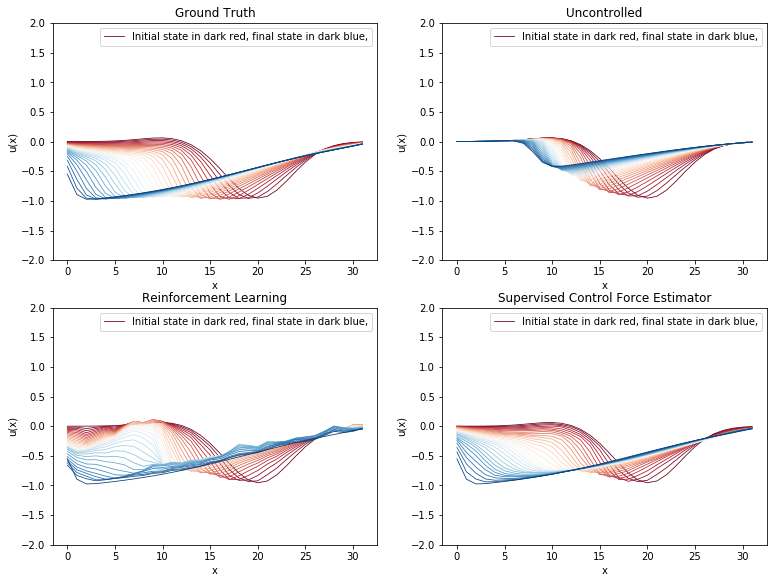

In [12]:
index_in_set = 8
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.6))

axs[0, 0].set_title('Ground Truth')
axs[0, 1].set_title('Uncontrolled')
axs[1, 0].set_title('Reinforcement Learning')
axs[1, 1].set_title('Supervised Control Force Estimator')

for subplot_idcs in [(0,0), (0,1), (1,0), (1,1)]:
    axs[subplot_idcs].set_ylim(-2, 2)
    axs[subplot_idcs].set_xlabel('x')
    axs[subplot_idcs].set_ylabel('u(x)')
    axs[subplot_idcs].legend(['Initial state in dark red, final state in dark blue,'])
    
def plot_w_label(xy, field): 
    color = bplt.gradient_color(0, step_count+1)
    axs[xy].plot(field[0][index_in_set].squeeze(), color=color, linewidth=0.8, label='Initial state in dark red, final state in dark blue,')
    axs[xy].legend()
    
# Plot the first states and create a legend for each plot
plot_w_label((0, 0), gt_frames)
plot_w_label((0, 1), pass_frames)
plot_w_label((1, 0), rl_frames)
plot_w_label((1, 1), cfe_frames)
    
# Plot the remaining states
for frame in range(1, step_count + 1):
    color = bplt.gradient_color(frame, step_count+1)
    plot = lambda xy, field: axs[xy].plot(field[frame][index_in_set].squeeze(), color=color, linewidth=0.8)
    plot((0,0), gt_frames)
    plot((0,1), pass_frames)
    plot((1,0), rl_frames)
    plot((1,1), cfe_frames)

In [13]:
def infer_forces(frames):
    frames = np.array(frames)
    
    b = Burgers(diffusion_substeps=diffusion_substeps)
    to_state = lambda v: BurgersVelocity(domain, velocity=v, viscosity=viscosity) 
        
    # Simulate all timesteps of all trajectories at once
    # => concatenate all frames in batch dimension
    prv = to_state(frames[:-1].reshape((-1,) + frames.shape[2:]))
    prv_sim = b.step(prv, dt=dt)
    
    forces = (frames[1:] - prv_sim.velocity.data.reshape(step_count, -1, *frames.shape[2:])) / dt
    
    # Sanity check, should be able to reconstruct goal state with forces
    s = to_state(frames[0])
    for i in range(step_count):
        f = forces[i].reshape(s.velocity.data.shape)
        effect = FieldEffect(CenteredGrid(f, box=domain.box), ['velocity'])
        s = b.step(s, dt, (effect,))
    diff = frames[-1] - s.velocity.data
    print('Maximum deviation from target state: %f' % np.abs(diff).max())
    return forces

    
gt_forces = np.abs(infer_forces(gt_frames)).sum(axis=(0, 2)).squeeze()
cfe_forces = np.abs(infer_forces(cfe_frames)).sum(axis=(0, 2)).squeeze()
rl_forces = rl_trainer.infer_test_set_forces()

Maximum deviation from target state: 0.000000
Maximum deviation from target state: 0.000000


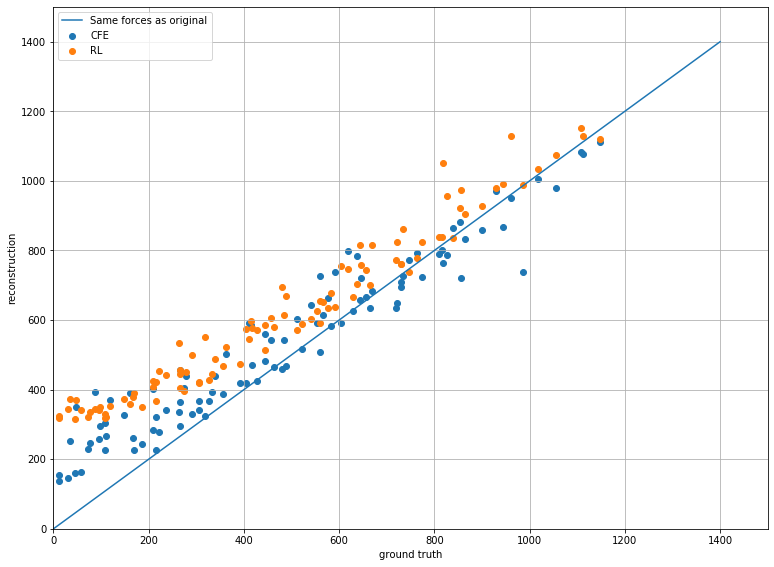

In [14]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(gt_forces, cfe_forces, label='CFE')
plt.scatter(gt_forces, rl_forces, label='RL')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces as original')
plt.xlabel('ground truth')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.ylabel('reconstruction')
plt.grid()
plt.legend()
plt.show()

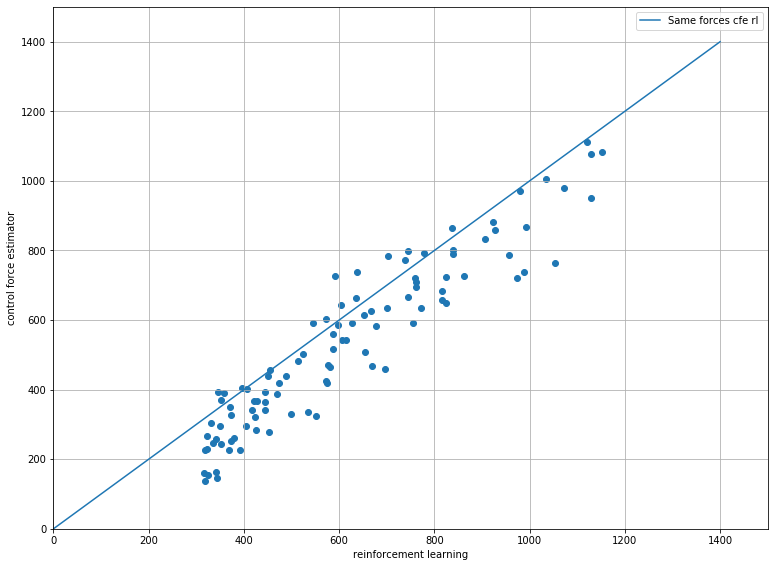

In [15]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(rl_forces, cfe_forces)
plt.xlabel('reinforcement learning')
plt.ylabel('control force estimator')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces cfe rl')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.grid()
plt.legend()
plt.show()

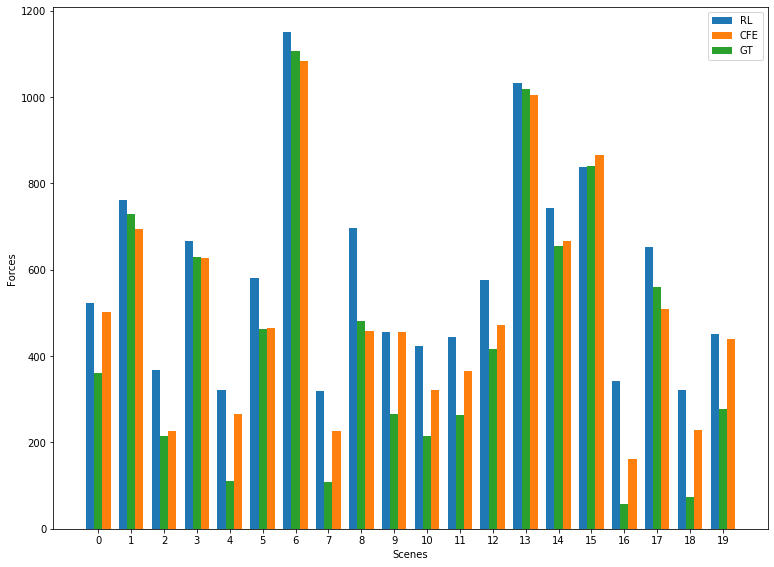

In [16]:
w=0.25
plot_count=20
plt.figure(figsize=(12.8, 9.6))
plt.bar([i - w for i in range(plot_count)], rl_forces[:plot_count], width=w, align='center', label='RL')
plt.bar([i + w for i in range(plot_count)], cfe_forces[:plot_count], width=w, align='center', label='CFE')
plt.bar([i for i in range(plot_count)], gt_forces[:plot_count], width=w, align='center', label='GT')
plt.xlabel('Scenes')
plt.xticks(range(plot_count))
plt.ylabel('Forces')
plt.legend()
plt.show()

Index(['time', 'iteration', 'forces'], dtype='object')
6396800


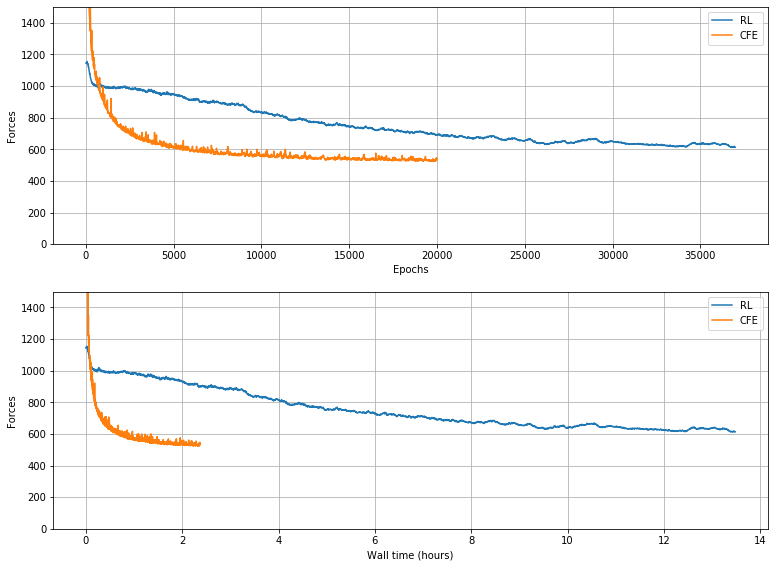

In [16]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import pandas as pd

def get_rl_test_set_forces(experiment_name):
    path_template = os.path.join('..', 'networks', 'rl-models', experiment_name, 'tensorboard-log', 'PPO_%i')
    i = 0
    w_times, step_nums, forces = [], [], []
    while os.path.exists(path_template % i):
        event_acc = EventAccumulator(path_template % i)
        event_acc.Reload()
        #print(event_acc.Scalars('test_set_forces'))
        new_w_times, new_step_nums, new_forces = zip(*event_acc.Scalars('test_set_forces'))
        new_w_times = np.array(new_w_times) - new_w_times[0]
        if i > 0:
            new_w_times += w_times[-1]
            new_step_nums = np.array(new_step_nums) + step_nums[-1]
        w_times += list(new_w_times)
        step_nums += list(new_step_nums)
        forces += new_forces
        i += 1
    return w_times, step_nums, forces
      
def get_cfe_test_set_forces(experiment_name):
    path = os.path.join('..', 'networks', 'cfe-models', experiment_name, 'test_forces.csv')
    table = pd.read_csv(path, skiprows=[])
    print(table.keys())
    return list(table['time']), list(table['iteration']), list(table['forces'])
    

#rl_w_times, rl_step_nums, rl_forces_during_training = zip(*event_acc.Scalars('test_set_forces'))
rl_w_times, rl_step_nums, rl_forces_during_training = get_rl_test_set_forces('bench')
cfe_w_times, cfe_step_nums, cfe_forces_during_training = get_cfe_test_set_forces('bench')

print(cfe_step_nums[-1])

fig, axs = plt.subplots(2, 1, figsize=(12.8, 9.6))

axs[0].plot(np.array(rl_step_nums) / 320, rl_forces_during_training, label='RL')
axs[0].plot(np.array(cfe_step_nums) / 320, cfe_forces_during_training, label='CFE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Forces')
axs[0].set_ylim(0, 1500)
axs[0].grid()
axs[0].legend()
axs[1].plot(np.array(rl_w_times) / 3600, rl_forces_during_training, label='RL')
axs[1].plot(np.array(cfe_w_times) / 3600, cfe_forces_during_training, label='CFE')
axs[1].set_xlabel('Wall time (hours)')
axs[1].set_ylabel('Forces')
axs[1].set_ylim(0, 1500)
axs[1].grid()
axs[1].legend()

fig.savefig('convergence_time_comparison.pdf')

plt.show()